# Web Scraping 

Realtor.com es una plataforma de bienes raíces en línea que facilita la compra, venta, y alquiler de propiedades en Estados Unidos. Operada por Move, Inc. y asociada con la National Association of Realtors, Realtor.com se destaca por su amplia base de datos y recursos informativos para el mercado inmobiliario.

El objetivo es realizar Web Scrpaing de las propiedades vendidas de California.

### 1. Importamos las librerias que vamos a utilizar para realizar el web scarping, limpieza de datos y modelado.

In [1]:
pip install unidecode

Note: you may need to restart the kernel to use updated packages.


In [220]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np 
from unidecode import unidecode

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Web Scraping
# ==============================================================================
from selenium import webdriver
import requests
import os
from bs4 import BeautifulSoup
import time
from selenium.webdriver.chrome.options import Options

### 2. Configuramos el navegador

Establecemos un tiempo de espera implícito de 10 segundos.

In [479]:
options = Options()
options.add_argument("--auto-open-devtools-for-tabs")  # Automatically open DevTools

driver = webdriver.Chrome(options=options)
driver.implicitly_wait(10)

### 3. Creamos la función para guardar la imágen principal de cada propiedad.

In [480]:
# Función para guardar imágenes
def save_image(image_url, filename, folder_path='zillow_images'):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    response = requests.get(image_url, stream=True)
    if response.status_code == 200:
        with open(os.path.join(folder_path, filename), 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)

### 4. Creamos un DataFrame formato CSV. 

Donde guardaremos la información de las propiedades a partir de la lista de diccionarios que vamos a crear.

In [22]:
# Crear un DataFrame a partir de la lista de diccionarios
df = pd.read_csv('zillow_listings.csv')
df.head()

,Address,Price,Beds,Baths,Square Feet,Date Sold
0,"2200 Sacramento St APT 206, San Francisco, CA ...",$1.72M,2.0,2.0,969.0,2024-02-16
1,"114 10th Ave, San Francisco, CA 94118",$1.85M,3.0,2.0,2181.0,2024-02-16
2,"1982 44th Ave, San Francisco, CA 94116",$1.45M,3.0,2.0,1150.0,2024-02-16
3,"2731 41st Ave, San Francisco, CA 94116",$1.31M,2.0,1.0,1012.0,2024-02-16
4,"216 Dorland St, San Francisco, CA 94114",$1.36M,2.0,2.0,1132.0,2024-02-16


In [482]:
# Aquí definimos properties_data como una lista vacía
properties_data = []

image_folder_path = 'zillow_images'

### 5. Creamos la función para comenzar con el web scraping

In [483]:
def extract_bold_items(list_item):
    try:
        if list_item:
            list_item_text_container = list_item.find('b')
            text = list_item_text_container.text if list_item_text_container != None else None
            if (text == '--' or text == None):
                return None
            return float(text.replace(',', ''))
    except Exception as e:
        print(f"Error: {e}")
        return None

def extract_data_from_url(url):
    max_scroll_distance = 9000
    current_scroll_distance = 500

    driver.get(url)
    time.sleep(20)

    while max_scroll_distance > 0:
        driver.execute_script(f"window.scrollTo({{ top: {current_scroll_distance}, behavior: 'smooth' }});")
        current_scroll_distance += 500
        max_scroll_distance -= 500
        time.sleep(2)
        
    time.sleep(10)
    driver.execute_script(f"window.scrollTo({{ top: 0, behavior: 'smooth' }});")

    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    listings = soup.find_all('li', class_='StyledListCardWrapper-srp__sc-wtsrtn-0')

    for i, listing in enumerate(listings):
        title = listing.find("title")
        is_loading = title.text if title else None
        if (is_loading == "Loading"):
            print(url + f" {i} was loading")
            continue

        # Extraer la información de cada propiedad
        try:
            address = listing.find(attrs={"data-test": "property-card-addr"}).text
            price = listing.find(attrs={"data-test": "property-card-price"}).text
            date_sold = listing.find('span', class_='StyledPropertyCardBadge-c11n-8-84-3__sc-6gojrl-0').text.replace('Sold ', '')
            date_sold = pd.to_datetime(date_sold)
            details_container = listing.find('ul', class_='StyledPropertyCardHomeDetailsList-c11n-8-84-3__sc-1xvdaej-0')
            details = details_container.find_all('li')
            details_length = len(details)
            beds = extract_bold_items(details[0]) if details_length > 0 else None
            baths = extract_bold_items(details[1]) if details_length > 1 else None
            sqft = extract_bold_items(details[2]) if details_length > 2 else None

            # # Añadir la fila a la lista de diccionarios
            properties_data.append({
                'Address': address,
                'Price': price,
                'Beds': beds,
                'Baths': baths,
                'Square Feet': sqft,
                'Date Sold': date_sold
            })

            # # Obtener URL de la imagen y guardarla
            image_element = listing.find('img')
            image_url = image_element.get('src')
            filename = f"{address.replace(' ', '_').replace(',', '').replace('|', '')}.jpg"
            save_image(image_url, filename, image_folder_path)
        except Exception as e:
            print(f"Error: {e} - {i} - {url}\n\n")

Tenemos que ejecutar este cuaderno varias veces para descargar cada página de listados, porque zillow bloquea los intentos múltiples.

In [484]:
# extract_data_from_url('https://www.zillow.com/ca/sold/')
# extract_data_from_url('https://www.zillow.com/ca/sold/2_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/3_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/4_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/5_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/6_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/7_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/8_p/')
#extract_data_from_url('https://www.zillow.com/ca/sold/9_p/')

https://www.zillow.com/ca/sold/9_p/ 2 was loading
Error: 'NoneType' object has no attribute 'text' - 12 - https://www.zillow.com/ca/sold/9_p/




In [485]:
# Cerrar el navegador
driver.quit()

In [486]:
print(properties_data)

[{'Address': '810 W Naomi Ave UNIT 6, Arcadia, CA 91007', 'Price': '$798,000', 'Beds': 3.0, 'Baths': 2.0, 'Square Feet': 1600.0, 'Date Sold': Timestamp('2024-02-16 00:00:00')}, {'Address': '709 Coronado Ter, Los Angeles, CA 90026', 'Price': '$1.33M', 'Beds': 3.0, 'Baths': 3.0, 'Square Feet': 1614.0, 'Date Sold': Timestamp('2024-02-16 00:00:00')}, {'Address': '726 N Las Palmas Ave, Los Angeles, CA 90038', 'Price': '$2.00M', 'Beds': 2.0, 'Baths': 2.0, 'Square Feet': 1765.0, 'Date Sold': Timestamp('2024-02-16 00:00:00')}, {'Address': '6830 De Longpre Ave, Los Angeles, CA 90028', 'Price': '$940,000', 'Beds': 2.0, 'Baths': 2.0, 'Square Feet': 910.0, 'Date Sold': Timestamp('2024-02-16 00:00:00')}, {'Address': '6700 Hillpark Dr APT 203, Los Angeles, CA 90068', 'Price': '$645,000', 'Beds': 2.0, 'Baths': 2.0, 'Square Feet': 1154.0, 'Date Sold': Timestamp('2024-02-16 00:00:00')}, {'Address': '7048 Macapa Dr, Los Angeles, CA 90068', 'Price': '$4.00M', 'Beds': 3.0, 'Baths': 3.0, 'Square Feet': 294

In [487]:
new_df = pd.DataFrame(properties_data)
df = pd.concat([df, new_df])
df.head()

,Address,Price,Beds,Baths,Square Feet,Date Sold
0,"2200 Sacramento St APT 206, San Francisco, CA ...",$1.72M,2.0,2.0,969.0,2024-02-16
1,"114 10th Ave, San Francisco, CA 94118",$1.85M,3.0,2.0,2181.0,2024-02-16
2,"1982 44th Ave, San Francisco, CA 94116",$1.45M,3.0,2.0,1150.0,2024-02-16
3,"2731 41st Ave, San Francisco, CA 94116",$1.31M,2.0,1.0,1012.0,2024-02-16
4,"216 Dorland St, San Francisco, CA 94114",$1.36M,2.0,2.0,1132.0,2024-02-16


In [488]:
# Guardar el DataFrame en un archivo CSV
df.to_csv('zillow_listings.csv', index=False)

In [489]:
df.shape

(324, 6)

# EDA - listing web scraping Zillow (df)

### 1. Cargamos el dataset 

In [3]:
df = pd.read_csv('zillow_listings.csv', encoding='utf-8', sep=',')

In [4]:
df.head()

,Address,Price,Beds,Baths,Square Feet,Date Sold
0,"2200 Sacramento St APT 206, San Francisco, CA ...",$1.72M,2.0,2.0,969.0,2024-02-16
1,"114 10th Ave, San Francisco, CA 94118",$1.85M,3.0,2.0,2181.0,2024-02-16
2,"1982 44th Ave, San Francisco, CA 94116",$1.45M,3.0,2.0,1150.0,2024-02-16
3,"2731 41st Ave, San Francisco, CA 94116",$1.31M,2.0,1.0,1012.0,2024-02-16
4,"216 Dorland St, San Francisco, CA 94114",$1.36M,2.0,2.0,1132.0,2024-02-16


In [5]:
df.tail()

,Address,Price,Beds,Baths,Square Feet,Date Sold
319,"2232 Daladier Dr, Rancho Palos Verdes, CA 90275",$1.68M,4.0,3.0,2948.0,2024-02-16 00:00:00
320,"27989 Beechgate Dr, Rancho Palos Verdes, CA 90275",$1.55M,4.0,3.0,2390.0,2024-02-16 00:00:00
321,"13218 La Jolla Cir UNIT C, La Mirada, CA 90638","$675,000",3.0,2.0,1271.0,2024-02-16 00:00:00
322,"14348 Flomar Dr, Whittier, CA 90603","$745,000",2.0,2.0,1479.0,2024-02-16 00:00:00
323,"816 Reed Dr, Claremont, CA 91711","$900,000",3.0,2.0,1610.0,2024-02-16 00:00:00


### Contamos el número de valores únicos de cada columna.

Comprobamos que de las 324 filas, tenemos 324 direcciones únicas, esto es un buen indicador conforme no tenemos datos duplicados.

In [13]:
df.nunique()

Address        324
Price          233
Beds             7
Baths            8
Square Feet    287
Date Sold        2
dtype: int64

### Comprobamos los valores únicos de unas columnas concretas.

In [14]:
df['Date Sold'].unique()

array(['2024-02-16', '2024-02-16 00:00:00'], dtype=object)

In [15]:
df['Baths'].unique()

array([2. , 1. , 4. , 3. , 7. , nan, 5. , 6. , 2.5])

In [16]:
df['Beds'].unique()

array([ 2.,  3.,  5.,  4.,  6., nan,  1.,  8.])

### Comprobamos el tamaño del dataset

In [17]:
df.shape

(324, 6)

### Comprobamos si tenemos valroes duplicados.

In [18]:
df.duplicated().sum()

0

### Comprobamos el tipo de valores que tiene cada una de las columnas.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Address      324 non-null    object 
 1   Price        324 non-null    object 
 2   Beds         319 non-null    float64
 3   Baths        319 non-null    float64
 4   Square Feet  320 non-null    float64
 5   Date Sold    324 non-null    object 
dtypes: float64(3), object(3)
memory usage: 15.3+ KB


### Comprobamos si existen valores NaN en cada columna.

In [20]:
df.isnull().sum()

Address        0
Price          0
Beds           5
Baths          5
Square Feet    4
Date Sold      0
dtype: int64

### Observaciones

Observamos que las 324 viviendas se vendieron el mismo día 16/02/2024. El día que realicé el scraping fué el 17/02. No tenemos datos duplicados.

· La columna **'Date Sold'** está en formato object, esta columna no la vamos a necesitar.  
· La columna **'price'** está en formato object, y contiene el simbolo $ y M.  
· La columna **'Baths'** está en formato float, lo mantenemos porque comprobamos que alguna fila tiene 2.5 baños. Tiene 5 valores nulos.
· La columna **'Beds'** está en formato float, la podemos convertir en int. Tiene 5 valores nulos.  
· La columna **'Square feet'** tiene 4 volores nulos.
· La columna **'Adress'** está en formato object, para facilitar el análisis es posible que separemos la información por población a través del código postal y población.

## Limpieza de Datos y Transformación de Datos

### Analisis estadístico

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Beds,319.0,3.197492,0.978637,1.0,3.00,3.0,4.00,8.0
Baths,319.0,2.474922,0.930441,1.0,2.00,2.0,3.00,7.0
Square Feet,320.0,1846.637500,809.449842,572.0,1271.75,1689.0,2182.25,5173.0


### Extracción de componentes 'Address'

Vamos a empezar por la columna **Adress** vamos a separar y crear nuevas columnas con la dirección, población, codigo postal y estado. Después eliminaremos el estado ya que solo estamos trabajando con datos de California.

In [22]:
# Separamos la dirección en nuevas columnas por cada coma
df[['Street', 'City', 'State_Zip']] = df['Address'].str.split(',', expand=True)

# Separamos el estado y el código postal en dos columnas distintas
df[['State', 'Zip']] = df['State_Zip'].str.strip().str.split(' ', expand=True)

# Eliminamos las columnas 'State_Zip', 'Adress' y State
df.drop(columns=['State_Zip','Address','State'], inplace=True)

df

,Price,Beds,Baths,Square Feet,Date Sold,Street,City,Zip
0,$1.72M,2.0,2.0,969.0,2024-02-16,2200 Sacramento St APT 206,San Francisco,94115
1,$1.85M,3.0,2.0,2181.0,2024-02-16,114 10th Ave,San Francisco,94118
2,$1.45M,3.0,2.0,1150.0,2024-02-16,1982 44th Ave,San Francisco,94116
3,$1.31M,2.0,1.0,1012.0,2024-02-16,2731 41st Ave,San Francisco,94116
4,$1.36M,2.0,2.0,1132.0,2024-02-16,216 Dorland St,San Francisco,94114
...,...,...,...,...,...,...,...,...
319,$1.68M,4.0,3.0,2948.0,2024-02-16 00:00:00,2232 Daladier Dr,Rancho Palos Verdes,90275
320,$1.55M,4.0,3.0,2390.0,2024-02-16 00:00:00,27989 Beechgate Dr,Rancho Palos Verdes,90275
321,"$675,000",3.0,2.0,1271.0,2024-02-16 00:00:00,13218 La Jolla Cir UNIT C,La Mirada,90638
322,"$745,000",2.0,2.0,1479.0,2024-02-16 00:00:00,14348 Flomar Dr,Whittier,90603


### 'Price'

Para transformar la columna del precio y manejar ambos formatos (por ejemplo, "$ 1.72M" y "$ 675,000"), primero eliminaremos el carácter '$', luego convertiremos los valores que terminan en 'M' a millones (multiplicándolos por 1,000,000) y finalmente eliminaremos las comas

In [23]:
# Eliminamos el carácter '$' y las comas de la columna 'Price'
df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '')

# Convertimos los valores que terminan en 'M' a su equivalente numérico en millones
# Primero, identificamos cuáles terminan en 'M' y luego convertimos
df['Price'] = df['Price'].apply(lambda x: float(x.rstrip('M')) * 1e6 if x.endswith('M') else float(x))

In [24]:
df

,Price,Beds,Baths,Square Feet,Date Sold,Street,City,Zip
0,1720000.0,2.0,2.0,969.0,2024-02-16,2200 Sacramento St APT 206,San Francisco,94115
1,1850000.0,3.0,2.0,2181.0,2024-02-16,114 10th Ave,San Francisco,94118
2,1450000.0,3.0,2.0,1150.0,2024-02-16,1982 44th Ave,San Francisco,94116
3,1310000.0,2.0,1.0,1012.0,2024-02-16,2731 41st Ave,San Francisco,94116
4,1360000.0,2.0,2.0,1132.0,2024-02-16,216 Dorland St,San Francisco,94114
...,...,...,...,...,...,...,...,...
319,1680000.0,4.0,3.0,2948.0,2024-02-16 00:00:00,2232 Daladier Dr,Rancho Palos Verdes,90275
320,1550000.0,4.0,3.0,2390.0,2024-02-16 00:00:00,27989 Beechgate Dr,Rancho Palos Verdes,90275
321,675000.0,3.0,2.0,1271.0,2024-02-16 00:00:00,13218 La Jolla Cir UNIT C,La Mirada,90638
322,745000.0,2.0,2.0,1479.0,2024-02-16 00:00:00,14348 Flomar Dr,Whittier,90603


### Imputar valores NaN de las variables 'Baths', 'Beds' y Square Feet

Antes de transformar las variables 'Baths', 'Beds' y Square Feet vamos a imputar los valores NaN. No vamos a eliminar columnas porque nuestro dataset es pequeño, lo que aplicaremos Media o Mediana al tener datos numéricos, imputar con la media o la mediana de la columna puede ser un enfoque rápido y efectivo, especialmente si la distribución de los datos es relativamente uniforme.

In [25]:
# Imputación con la media para 'Beds'y'Baths' 
df['Beds'] = df['Beds'].fillna(df['Beds'].mean())
df['Baths'] = df['Baths'].fillna(df['Baths'].mean())

In [26]:
# Imputación con la mediana para 'Square Feet'
df['Square Feet'] = df['Square Feet'].fillna(df['Square Feet'].median())

In [27]:
# Comprobamos que no quede ningún valor NaN
df.isnull().sum()

Price          0
Beds           0
Baths          0
Square Feet    0
Date Sold      0
Street         0
City           0
Zip            0
dtype: int64

### 'Baths'

Nos encontramos que en los valores de Baths, existen 'medios' que corresponden a aseos, no medios baños, lo que realizaremos a continuación, es crear una nueva columna con el número de aseos, y convertiremos la columna Beds, Baths y toilets en int (números eneteros).

### 1. Crear una nueva columna 'Toilets' basada en si 'Baths' tiene un valor decimal. (0.5)

In [28]:
# El número de aseos será el decimal multiplicado por 2 (asumiendo que .5 representa un aseo).
df['Toilets'] = (df['Baths'] % 1) * 2

In [29]:
# Imputación con la media para 'Toilets'
df['Toilets'] = df['Toilets'].fillna(df['Toilets'].mean())

In [30]:
# Convertir la columna 'Toilets' a entero, ya que la operación anterior está en un número flotante.
df['Toilets'] = df['Toilets'].astype(int)

In [31]:
# Redondeamos 'Baths' hacia abajo para eliminar la parte decimal y luego convertimos a entero.
df['Baths'] = df['Baths'].apply(lambda x: int(x)) 

In [32]:
# Comprobamos que se haya creado correctamente la columna 'Toilet'
df['Toilets'].unique()

array([0, 1])

In [33]:
#Comprobamos cuántos valores 0 y 1 hay en 'Toilets'
df['Toilets'].value_counts()

Toilets
0    323
1      1
Name: count, dtype: int64

Observamos que solo tenemos 1, decido mantenerlo.

### 2. Convertimos 'Beds' a números enteros

In [34]:
# Aseguramos que 'Beds' también sea de tipo entero, por si acaso.
df['Beds'] = df['Beds'].astype(int)

In [35]:
df

,Price,Beds,Baths,Square Feet,Date Sold,Street,City,Zip,Toilets
0,1720000.0,2,2,969.0,2024-02-16,2200 Sacramento St APT 206,San Francisco,94115,0
1,1850000.0,3,2,2181.0,2024-02-16,114 10th Ave,San Francisco,94118,0
2,1450000.0,3,2,1150.0,2024-02-16,1982 44th Ave,San Francisco,94116,0
3,1310000.0,2,1,1012.0,2024-02-16,2731 41st Ave,San Francisco,94116,0
4,1360000.0,2,2,1132.0,2024-02-16,216 Dorland St,San Francisco,94114,0
...,...,...,...,...,...,...,...,...,...
319,1680000.0,4,3,2948.0,2024-02-16 00:00:00,2232 Daladier Dr,Rancho Palos Verdes,90275,0
320,1550000.0,4,3,2390.0,2024-02-16 00:00:00,27989 Beechgate Dr,Rancho Palos Verdes,90275,0
321,675000.0,3,2,1271.0,2024-02-16 00:00:00,13218 La Jolla Cir UNIT C,La Mirada,90638,0
322,745000.0,2,2,1479.0,2024-02-16 00:00:00,14348 Flomar Dr,Whittier,90603,0


### Eliminamos la columna 'Date Sold'

In [36]:
df.drop('Date Sold',axis=1, inplace=True)

In [37]:
df

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,San Francisco,94115,0
1,1850000.0,3,2,2181.0,114 10th Ave,San Francisco,94118,0
2,1450000.0,3,2,1150.0,1982 44th Ave,San Francisco,94116,0
3,1310000.0,2,1,1012.0,2731 41st Ave,San Francisco,94116,0
4,1360000.0,2,2,1132.0,216 Dorland St,San Francisco,94114,0
...,...,...,...,...,...,...,...,...
319,1680000.0,4,3,2948.0,2232 Daladier Dr,Rancho Palos Verdes,90275,0
320,1550000.0,4,3,2390.0,27989 Beechgate Dr,Rancho Palos Verdes,90275,0
321,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,La Mirada,90638,0
322,745000.0,2,2,1479.0,14348 Flomar Dr,Whittier,90603,0


### Analizamos el formato de cada columna

In [38]:
df.dtypes

Price          float64
Beds             int32
Baths            int64
Square Feet    float64
Street          object
City            object
Zip             object
Toilets          int32
dtype: object

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        324 non-null    float64
 1   Beds         324 non-null    int32  
 2   Baths        324 non-null    int64  
 3   Square Feet  324 non-null    float64
 4   Street       324 non-null    object 
 5   City         324 non-null    object 
 6   Zip          324 non-null    object 
 7   Toilets      324 non-null    int32  
dtypes: float64(2), int32(2), int64(1), object(3)
memory usage: 17.8+ KB


In [40]:
df

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,San Francisco,94115,0
1,1850000.0,3,2,2181.0,114 10th Ave,San Francisco,94118,0
2,1450000.0,3,2,1150.0,1982 44th Ave,San Francisco,94116,0
3,1310000.0,2,1,1012.0,2731 41st Ave,San Francisco,94116,0
4,1360000.0,2,2,1132.0,216 Dorland St,San Francisco,94114,0
...,...,...,...,...,...,...,...,...
319,1680000.0,4,3,2948.0,2232 Daladier Dr,Rancho Palos Verdes,90275,0
320,1550000.0,4,3,2390.0,27989 Beechgate Dr,Rancho Palos Verdes,90275,0
321,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,La Mirada,90638,0
322,745000.0,2,2,1479.0,14348 Flomar Dr,Whittier,90603,0


### Análisis de Frecuencia de Direcciones

Analizaremos la frecuencia de las direcciones para identificar las más comunes y posibles agrupaciones geográficas. 

In [41]:
# Contar la frecuencia de cada ciudad
df['City'].value_counts()

City
 San Diego        20
 Los Angeles      14
 San Jose         11
 San Francisco    10
 San Mateo         7
                  ..
 Paradise          1
 Oroville          1
 Murrieta          1
 Lodi              1
 Claremont         1
Name: count, Length: 171, dtype: int64

Observamos que lo encabeza San Diego, luego Los Angeles, San José y San Francisco. Disponemos de poca data para poder hacer la predicción. Es por eso que utilizaremos otro dataframe, con precios medios de las zonas para que acabe de completar la información.

## Comprobamos si hay outliers (valores atípicos) en nuestro DataFrame

### Boxplot para la columna 'Square Feet'

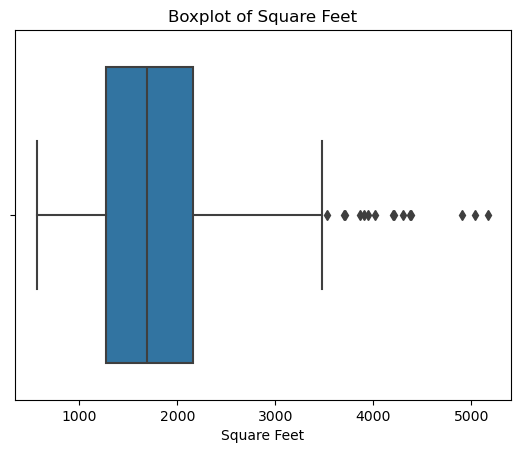

In [42]:
sns.boxplot(x=df['Square Feet'])
plt.title('Boxplot of Square Feet')
plt.show()

Observamos que disponemos de 3 viviendas con 5000 m2 (outliers).

### Análisis Estadístico  'Square Feet'

**Rango Intercuartílico (IQR)**  
El IQR es la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1). Los valores que se encuentran por debajo de Q1 - 1.5 * IQR o por encima de Q3 + 1.5 * IQR suelen considerarse outliers.

In [43]:
# Calcular el IQR para 'Square Feet'
Q1 = df['Square Feet'].quantile(0.25)
Q3 = df['Square Feet'].quantile(0.75)
IQR = Q3 - Q1

# Identificar outliers
outliers = df[(df['Square Feet'] < (Q1 - 1.5 * IQR)) | (df['Square Feet'] > (Q3 + 1.5 * IQR))]
print(f"Número de outliers en 'Square Feet' según el Rango Intercuartílico: {len(outliers)}")

Número de outliers en 'Square Feet' según el Rango Intercuartílico: 15


### Boxplot para la columna 'Beds'

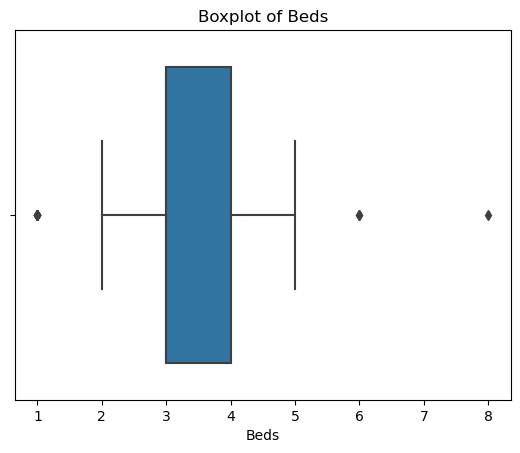

In [44]:
sns.boxplot(x=df['Beds'])
plt.title('Boxplot of Beds')
plt.show()

En el caso de las habitaciones 'Beds' observamos que tenemos 3 viviendas (outliers) una con 1 habitación, otra con 6 y otra con 8.

### Boxplot para la columna 'Baths'

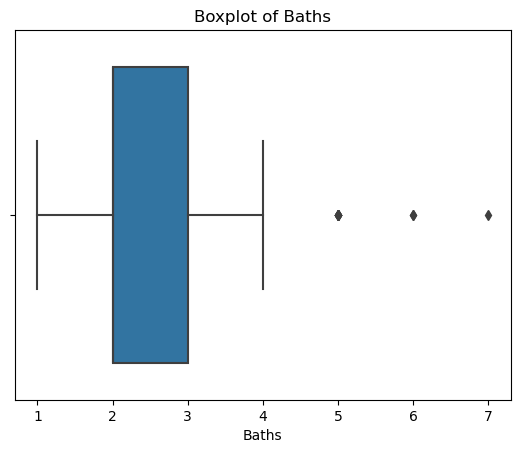

In [45]:
sns.boxplot(x=df['Baths'])
plt.title('Boxplot of Baths')
plt.show()

Y en el caso de baños también tenemos 3 viviendas (outliers) con más de 5 baños, 6 y 7. 

### Identificar Outliers
Primero, identificaremos los outliers en cada una de las columnas basándome en lo observado en los boxplots:

In [46]:
# Outliers en 'Square Feet'
outliers_square_feet = df[df['Square Feet'] == 5000]

# Outliers en 'Beds'
outliers_beds = df[df['Beds'].isin([1, 6, 8])]

# Outliers en 'Baths'
outliers_baths = df[df['Baths'] > 5]  # Esto captura viviendas con más de 5 baños, incluyendo 6 y 7

### Comprobar Coincidencias
Para comprobar si los outliers coinciden en los tres casos, vamos a utilizar los índices de los DataFrames filtrados. El objetivo es encontrar índices que estén presentes en los tres conjuntos de outliers:

In [47]:
# Intersección de índices
indices_square_feet = set(outliers_square_feet.index)
indices_beds = set(outliers_beds.index)
indices_baths = set(outliers_baths.index)

# Encuentra la intersección de los índices para ver si coinciden los mismos outliers
coincident_outliers_indices = indices_square_feet.intersection(indices_beds).intersection(indices_baths)

# Verificar si hay coincidencias
if coincident_outliers_indices:
    print(f"Índices de viviendas que son outliers en las tres categorías: {coincident_outliers_indices}")
    # Opcional: Mostrar las viviendas que coinciden
    coincident_outliers = df.loc[coincident_outliers_indices]
    print(coincident_outliers)
else:
    print("No hay viviendas que sean outliers en las tres categorías simultáneamente.")


No hay viviendas que sean outliers en las tres categorías simultáneamente.


In [48]:
df

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,San Francisco,94115,0
1,1850000.0,3,2,2181.0,114 10th Ave,San Francisco,94118,0
2,1450000.0,3,2,1150.0,1982 44th Ave,San Francisco,94116,0
3,1310000.0,2,1,1012.0,2731 41st Ave,San Francisco,94116,0
4,1360000.0,2,2,1132.0,216 Dorland St,San Francisco,94114,0
...,...,...,...,...,...,...,...,...
319,1680000.0,4,3,2948.0,2232 Daladier Dr,Rancho Palos Verdes,90275,0
320,1550000.0,4,3,2390.0,27989 Beechgate Dr,Rancho Palos Verdes,90275,0
321,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,La Mirada,90638,0
322,745000.0,2,2,1479.0,14348 Flomar Dr,Whittier,90603,0


### Normalizamos los datos de la columna City

In [49]:
# Normalizar la columna 'City'
df['City'] = df['City'].str.lower().str.strip().str.replace(r'\s+', ' ', regex=True)


In [50]:
# Mostrar el DataFrame resultante para verificar los cambios
df.head()

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,san francisco,94115,0
1,1850000.0,3,2,2181.0,114 10th Ave,san francisco,94118,0
2,1450000.0,3,2,1150.0,1982 44th Ave,san francisco,94116,0
3,1310000.0,2,1,1012.0,2731 41st Ave,san francisco,94116,0
4,1360000.0,2,2,1132.0,216 Dorland St,san francisco,94114,0


## Análisis descriptivo y visual de los datos

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,324.0,1.094866e+06,910355.043695,4100.0,580000.00,822500.0,1410000.00,8140000.0
Beds,324.0,3.194444e+00,0.971338,1.0,3.00,3.0,4.00,8.0
Baths,324.0,2.466049e+00,0.925434,1.0,2.00,2.0,3.00,7.0
Square Feet,324.0,1.844691e+03,804.611048,572.0,1275.75,1689.0,2156.25,5173.0
Toilets,324.0,3.086420e-03,0.055556,0.0,0.00,0.0,0.00,1.0


Observamos que:  
**Rango de Precios Amplio**: Los precios de las propiedades varían considerablemente, desde $4,100 hasta $8,140,000, destacando una diversa gama de propiedades que abarca desde opciones muy accesibles hasta residencias de lujo.

**Precio Promedio**: El precio promedio es relativamente alto, situándose en $1,094,866.29, lo cual, junto con un desvío estándar significativo de $910,355.04, indica una considerable variabilidad en los precios de las propiedades.

**Tamaño de las Propiedades**: Las propiedades tienen un rango de tamaño desde 572 hasta 5,173 pies cuadrados, con una media de 1,844.69 pies cuadrados, sugiriendo que la mayoría de las propiedades son de tamaño moderado a grande.

**Cantidad de Habitaciones**: La mayoría de las propiedades tienen entre 3 y 4 habitaciones, lo que indica que el dataset tiende a incluir propiedades de tamaño medio a grande, adecuadas para familias.

En cuanto la fecha de venta 'Sold Date' es la misma, debido a que solo realizé el web scarping a 324 propiedades vendidas en la misma fecha.

## Visualización de Distribuciones

Realizamos un histograma de cada una de las variables. 

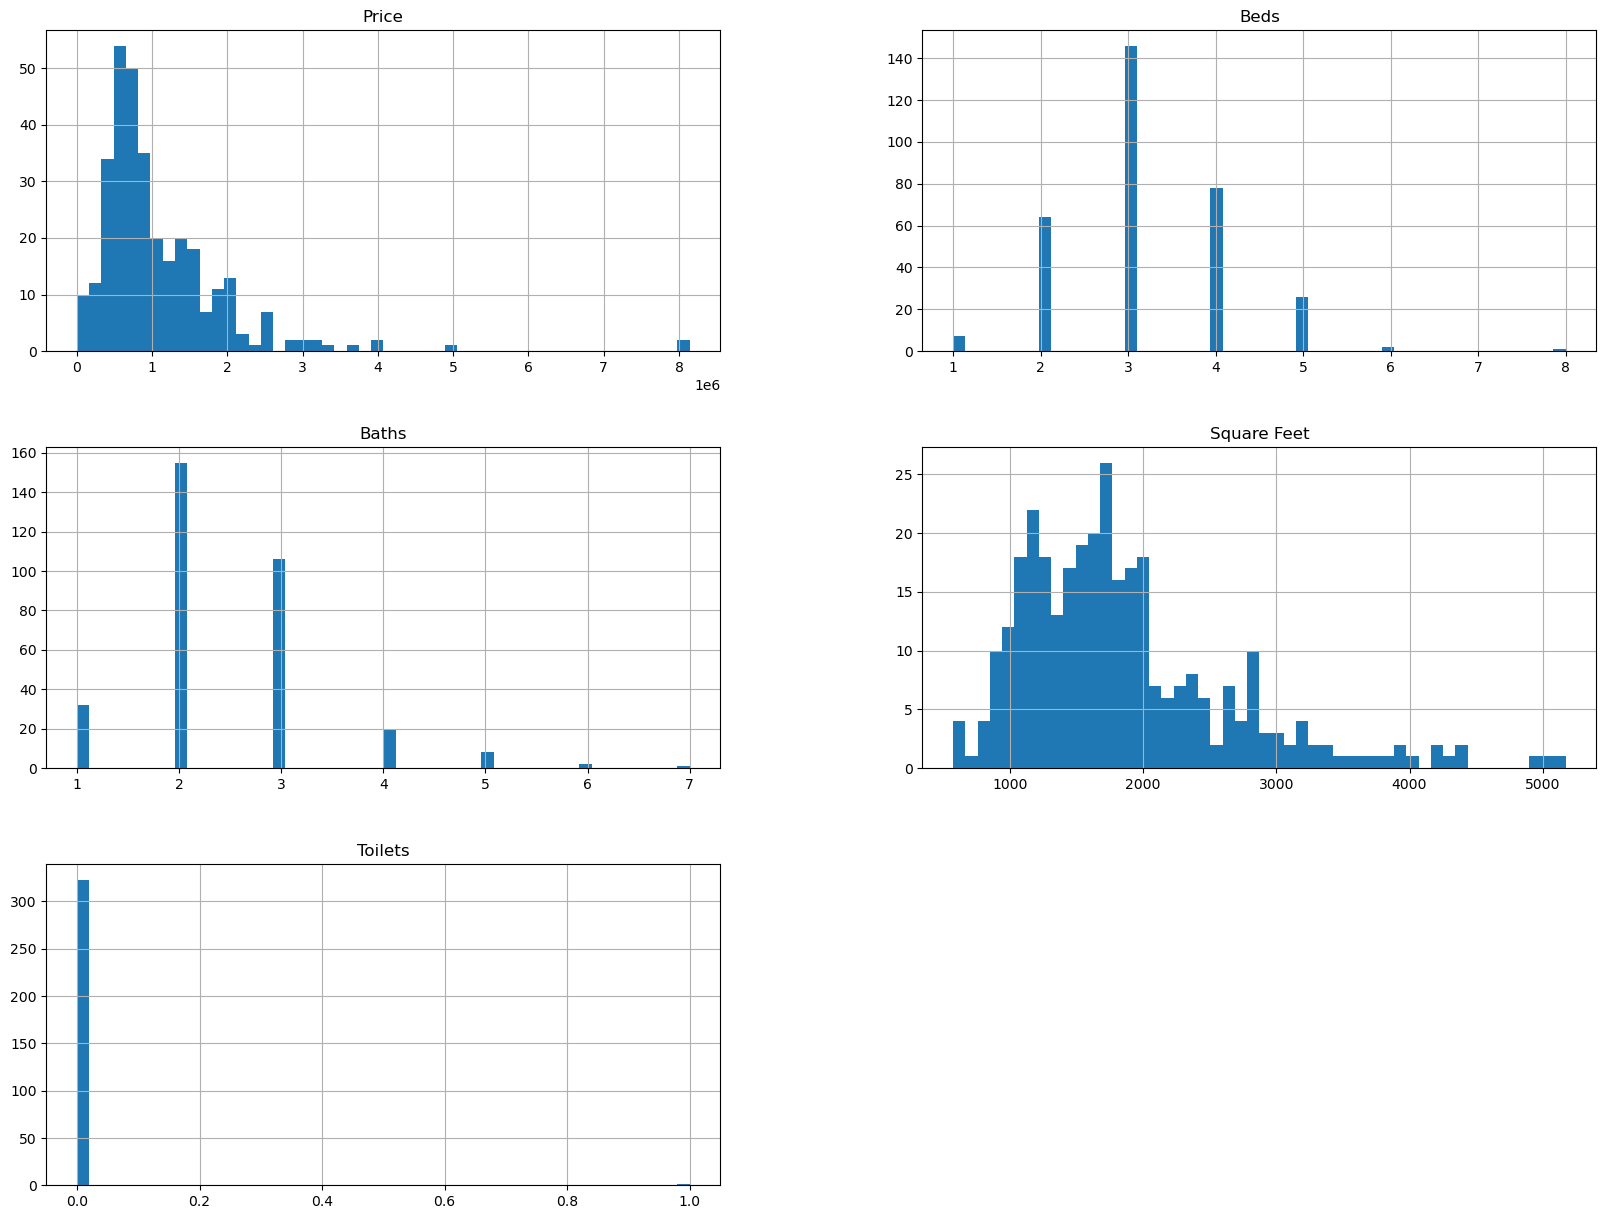

In [52]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Observaciones: 
- La mayoría de las propiedades tienen entre 2 y 3 habitaciones, lo que indica que el dataset tiende a incluir propiedades de tamaño medio a grande, adecuadas para familias.  
- El precio promedio es relativamente alto, situándose en $1,094,866.29, lo cual, junto con un desvío estándar significativo de $910,355.04, indica una considerable variabilidad en los precios de las propiedades.
- La mayoría de las propiedades tienen un tamaño entre 572 y 5,173 pies cuadrados, con una media de 1,844.69 pies cuadrados, sugiriendo que la mayoría de las propiedades son de tamaño moderado a grande.  

En cuanto los baños, y la fecha de venta. No es relevante.

## Análisis de Relaciones

### Scatter Plots - relación entre 'Square Feet' y 'Price' 

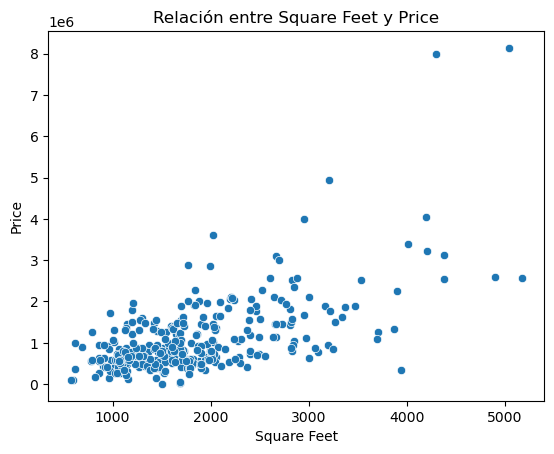

In [53]:
# Relación entre 'Square Feet' y 'Price'
sns.scatterplot(x='Square Feet', y='Price', data=df)
plt.title('Relación entre Square Feet y Price')
plt.show()

En el gráfico podemos observar que el 'groso' entre los 1000 m2 y 2000m2

### Scatter Plots - relación entre 'Square Feet' y 'Price' según las TOP 10 'City'

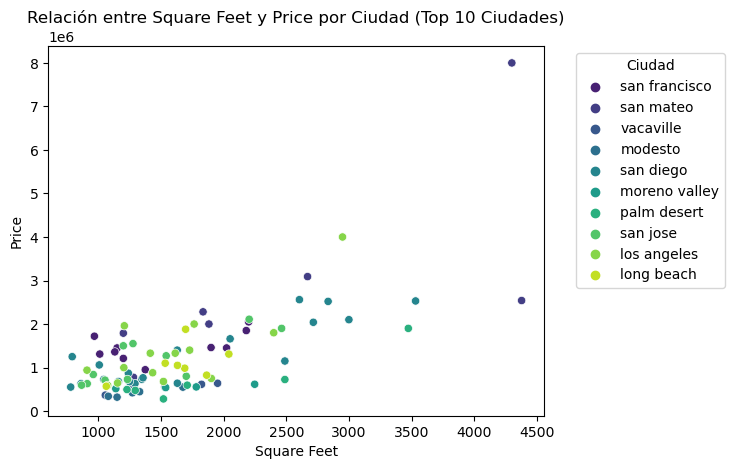

In [54]:
# Primero, identificamos las 10 ciudades con más viviendas vendidas
top_cities = df['City'].value_counts().head(10).index

# Filtramos el DataFrame para incluir solo esas ciudades
df_top_cities = df[df['City'].isin(top_cities)]

# Ahora, creamos el scatter plot para las viviendas en estas ciudades
sns.scatterplot(x='Square Feet', y='Price', hue='City', data=df_top_cities, palette='viridis')
plt.title('Relación entre Square Feet y Price por Ciudad (Top 10 Ciudades)')
plt.xlabel('Square Feet')
plt.ylabel('Price')
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left')  # Ajusta la leyenda fuera del gráfico
plt.show()

In [55]:
top_cities

Index(['san diego', 'los angeles', 'san jose', 'san francisco', 'san mateo',
       'long beach', 'palm desert', 'vacaville', 'modesto', 'moreno valley'],
      dtype='object', name='City')

He filtrado por las TOP 10 ciudades con más ventas de California (recordemos que es una pequeña muestra de 324 viviendas vendidas de un día en concreto 16/02/24). Observamos que existen dos "outliers" por el color identifico que son viviendas en San Mateo que tienen más de 4000m2, el resto se concentra en el mismo rango que en la gráfica anterior.

In [81]:
#exportamos df a csv
df.to_csv('df.csv')

¿¿Codificación de Variables Categóricas??
Para convertir variables categóricas (como 'City''Street', ) en un formato numérico **SI ANTES DE MODELAR**

# EDA - RDC_Inventory_Core_Metrics_County (df_realtor)

Este dataset es obtenido a través de la web de realtor, tiene datos de mercado (de California) que nos pueden ayudar a completar nuestro análisis.

### 1. Cargamos el dataset

In [133]:
df_realtor = pd.read_csv('RDC_Inventory_Core_Metrics_County.csv', encoding='utf-8', sep=',')

In [134]:
df_realtor.head()

,month_date_yyyymm,county_fips,county_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag
0,202401,46123,"tripp, sd",257500.0,0.0510,0.0300,4.0,-0.2000,-0.6190,110.0,...,4516288.0,0.2389,1.4495,6.0,0.0000,-0.4783,0.5000,0.3000,0.4048,1.0
1,202401,08057,"jackson, co",718750.0,0.3690,0.0636,6.0,-0.1429,2.0000,145.0,...,1560357.0,0.0740,1.3091,7.0,-0.0714,0.6250,0.1667,0.0238,-0.8333,1.0
2,202401,47117,"marshall, tn",370875.0,-0.0084,0.1154,116.0,-0.1145,-0.0128,74.0,...,507072.0,-0.0038,0.0459,139.0,-0.1146,-0.0211,0.1940,-0.0121,-0.0528,0.0
3,202401,05143,"washington, ar",398468.0,0.0088,-0.0123,569.0,-0.0741,0.1071,76.0,...,522550.0,0.0082,-0.0180,931.0,-0.0553,0.0065,0.6482,0.0391,-0.1541,0.0
4,202401,27159,"wadena, mn",237425.0,-0.0103,0.0731,38.0,-0.1163,0.5200,103.0,...,277465.0,0.0001,0.1770,52.0,-0.0714,0.4444,0.3816,0.0560,-0.0584,1.0


In [135]:
df_realtor.tail()

,month_date_yyyymm,county_fips,county_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag
3109,202401,30069,"petroleum, mt",310000.0,0.0000,-0.1842,6.0,0.0,1.0,124.0,...,399871.0,0.2406,0.0523,8.0,0.2500,1.5,0.2500,NaN,NaN,1.0
3110,202401,05073,"lafayette, ar",272625.0,0.5534,1.0614,11.0,0.0,4.5,138.0,...,372028.0,0.0865,1.8131,12.0,0.0909,5.0,0.0909,NaN,NaN,1.0
3111,202401,02180,"nome, ak",257500.0,-0.0077,-0.5522,2.0,-0.5,1.0,110.0,...,257500.0,-0.0039,-0.5522,2.0,-0.5000,1.0,NaN,NaN,NaN,1.0
3112,202401,02164,"lake and peninsula, ak",300000.0,0.0000,-0.0769,4.0,0.0,3.0,274.0,...,1066000.0,-0.0231,2.2800,4.0,0.0000,3.0,NaN,NaN,NaN,1.0
3113,quality_flag = 1: year-over-year figures may ...,please contact economics@realtor.com for more...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Vista general del DataFrame

Comprobamos el número de filas y columnas que tiene el DataFrame.

In [136]:
df_realtor.shape

(3114, 40)

In [137]:
df_realtor.dtypes

month_date_yyyymm                           object
county_fips                                 object
county_name                                 object
median_listing_price                       float64
median_listing_price_mm                    float64
median_listing_price_yy                    float64
active_listing_count                       float64
active_listing_count_mm                    float64
active_listing_count_yy                    float64
median_days_on_market                      float64
median_days_on_market_mm                   float64
median_days_on_market_yy                   float64
new_listing_count                          float64
new_listing_count_mm                       float64
new_listing_count_yy                       float64
price_increased_count                      float64
price_increased_count_mm                   float64
price_increased_count_yy                   float64
price_reduced_count                        float64
price_reduced_count_mm         

Observamos que la variable 'county_fips' y 'county_name' es de tipo object (categoría). La variable 'month_date_yyyymm' es de tipo object, lo cual quiere decir que la tenemos que convertir en formato fecha. El resto de variables están en formato float.

Comprobamos junto con la documentación que están todas las columnas, y analizamos las más relevantes para nuestro proyecto.

In [138]:
df_realtor.columns

Index(['month_date_yyyymm', 'county_fips', 'county_name',
       'median_listing_price', 'median_listing_price_mm',
       'median_listing_price_yy', 'active_listing_count',
       'active_listing_count_mm', 'active_listing_count_yy',
       'median_days_on_market', 'median_days_on_market_mm',
       'median_days_on_market_yy', 'new_listing_count', 'new_listing_count_mm',
       'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_listing_count',
       'pending_listing_count_mm', 'pending_listing_count_yy',
       'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy', 'total_l

### Análisis de Valores Faltantes

In [139]:
df_realtor.isnull().sum()

month_date_yyyymm                             0
county_fips                                   0
county_name                                   1
median_listing_price                          1
median_listing_price_mm                       5
median_listing_price_yy                      21
active_listing_count                          1
active_listing_count_mm                       5
active_listing_count_yy                      22
median_days_on_market                         1
median_days_on_market_mm                      5
median_days_on_market_yy                     21
new_listing_count                             1
new_listing_count_mm                        505
new_listing_count_yy                        347
price_increased_count                         1
price_increased_count_mm                   2536
price_increased_count_yy                   2369
price_reduced_count                           1
price_reduced_count_mm                      734
price_reduced_count_yy                  

### Imputación de Datos

Como el número de columnas que representan valores faltantes es muy significativo, vamos a imputar los valores faltantes para todas las columnas numéricas utilizando la mediana de cada columna.

In [140]:
import numpy as np
for column in df_realtor.select_dtypes(include=np.number).columns:
    df_realtor[column].fillna(df_realtor[column].median(), inplace=True)

In [141]:
#'county_name' es la única columna categórica que necesita imputación, en este caso como solo tenemos 1 aplicaremos la moda.
df_realtor['county_name'].fillna(df_realtor['county_name'].mode()[0], inplace=True)

### Eliminación de Datos

En casos donde la cantidad de datos faltantes es abrumadora (e.g., price_increased_count_mm, price_increased_count_yy), y la columna no es esencial para nuestro análisis o modelo predictivo, hemos considerado eliminar la columna completa.

In [142]:
# Eliminación de columnas con una gran cantidad de valores faltantes
columns_to_drop = ['price_increased_count_mm', 'price_increased_count_yy'] 
df_realtor.drop(columns=columns_to_drop, inplace=True)


In [143]:
#realizamos la comprobación
df_realtor.isnull().sum()

month_date_yyyymm                          0
county_fips                                0
county_name                                0
median_listing_price                       0
median_listing_price_mm                    0
median_listing_price_yy                    0
active_listing_count                       0
active_listing_count_mm                    0
active_listing_count_yy                    0
median_days_on_market                      0
median_days_on_market_mm                   0
median_days_on_market_yy                   0
new_listing_count                          0
new_listing_count_mm                       0
new_listing_count_yy                       0
price_increased_count                      0
price_reduced_count                        0
price_reduced_count_mm                     0
price_reduced_count_yy                     0
pending_listing_count                      0
pending_listing_count_mm                   0
pending_listing_count_yy                   0
median_lis

Elimino la columna 'quality_flag' porque no es relevante para el análisis.

In [144]:
df_realtor.drop('quality_flag', axis=1, inplace=True)

In [145]:
df_realtor.nunique()

month_date_yyyymm                             2
county_fips                                3114
county_name                                3113
median_listing_price                       2379
median_listing_price_mm                    1639
median_listing_price_yy                    2467
active_listing_count                        642
active_listing_count_mm                    1437
active_listing_count_yy                    2119
median_days_on_market                       189
median_days_on_market_mm                   2161
median_days_on_market_yy                   2526
new_listing_count                           311
new_listing_count_mm                        635
new_listing_count_yy                        796
price_increased_count                        71
price_reduced_count                         230
price_reduced_count_mm                      505
price_reduced_count_yy                      658
pending_listing_count                       472
pending_listing_count_mm                

In [146]:
df_realtor['county_name'].unique()

array(['tripp, sd', 'jackson, co', 'marshall, tn', ..., 'lafayette, ar',
       'nome, ak', 'lake and peninsula, ak'], dtype=object)

In [147]:
df_realtor['county_name'].value_counts()

county_name
abbeville, sc             2
tripp, sd                 1
berrien, ga               1
crook, or                 1
crane, tx                 1
                         ..
hockley, tx               1
walton, fl                1
bourbon, ky               1
allamakee, ia             1
lake and peninsula, ak    1
Name: count, Length: 3113, dtype: int64

Observamos que la coluna county_name tiene las iniciales del condado en la misma columna, lo que vamos a realizar a continuación es separar esta información para que solo quede el nombre del condado

In [148]:
# Dividir la columna 'county_name' en 'county' y 'initials', eliminando la coma
df_realtor[['county', 'initials']] = df_realtor['county_name'].str.rsplit(', ', n=1, expand=True)

# Eliminar cualquier espacio en blanco o caracteres adicionales si es necesario
df_realtor['county'] = df_realtor['county'].str.strip()
df_realtor['initials'] = df_realtor['initials'].str.strip()

In [149]:
df_realtor[['county', 'initials']].head()

,county,initials
0,tripp,sd
1,jackson,co
2,marshall,tn
3,washington,ar
4,wadena,mn


Eliminamos la columna 'county_name' porque ya no es necesaria.

In [150]:
df_realtor.drop('county_name', axis=1, inplace=True)

Eliminamos la columna initials porque ya no es necesaria. 

In [151]:
df_realtor.drop('initials', axis=1, inplace=True)

Y eliminamos la útima fila por que tampoco nos aporta información relevante. 

In [152]:
df_realtor.drop(df_realtor.tail(1).index, inplace=True)

Comprobamos que la última fila ha sido eliminada.

In [153]:
df_realtor.tail()

,month_date_yyyymm,county_fips,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,county
3108,202401,20097,274999.0,0.2500,3.5910,1.0,-0.6667,0.0,83.0,0.1458,...,274999.0,0.4474,3.5910,2.0,-0.3333,1.0,1.0000,0.0176,0.50000,kiowa
3109,202401,30069,310000.0,0.0000,-0.1842,6.0,0.0000,1.0,124.0,0.1923,...,399871.0,0.2406,0.0523,8.0,0.2500,1.5,0.2500,0.0176,-0.01985,petroleum
3110,202401,05073,272625.0,0.5534,1.0614,11.0,0.0000,4.5,138.0,0.2972,...,372028.0,0.0865,1.8131,12.0,0.0909,5.0,0.0909,0.0176,-0.01985,lafayette
3111,202401,02180,257500.0,-0.0077,-0.5522,2.0,-0.5000,1.0,110.0,-0.1852,...,257500.0,-0.0039,-0.5522,2.0,-0.5000,1.0,0.3852,0.0176,-0.01985,nome
3112,202401,02164,300000.0,0.0000,-0.0769,4.0,0.0000,3.0,274.0,0.0984,...,1066000.0,-0.0231,2.2800,4.0,0.0000,3.0,0.3852,0.0176,-0.01985,lake and peninsula


y eliminamos la columna month_date_yyyymm porque ya no es necesaria. 


In [154]:
df_realtor.drop('month_date_yyyymm', axis=1, inplace=True)

In [155]:
df_realtor.dtypes

county_fips                                 object
median_listing_price                       float64
median_listing_price_mm                    float64
median_listing_price_yy                    float64
active_listing_count                       float64
active_listing_count_mm                    float64
active_listing_count_yy                    float64
median_days_on_market                      float64
median_days_on_market_mm                   float64
median_days_on_market_yy                   float64
new_listing_count                          float64
new_listing_count_mm                       float64
new_listing_count_yy                       float64
price_increased_count                      float64
price_reduced_count                        float64
price_reduced_count_mm                     float64
price_reduced_count_yy                     float64
pending_listing_count                      float64
pending_listing_count_mm                   float64
pending_listing_count_yy       

In [156]:
df_realtor.dtypes

county_fips                                 object
median_listing_price                       float64
median_listing_price_mm                    float64
median_listing_price_yy                    float64
active_listing_count                       float64
active_listing_count_mm                    float64
active_listing_count_yy                    float64
median_days_on_market                      float64
median_days_on_market_mm                   float64
median_days_on_market_yy                   float64
new_listing_count                          float64
new_listing_count_mm                       float64
new_listing_count_yy                       float64
price_increased_count                      float64
price_reduced_count                        float64
price_reduced_count_mm                     float64
price_reduced_count_yy                     float64
pending_listing_count                      float64
pending_listing_count_mm                   float64
pending_listing_count_yy       

### Análisis de Correlación

Vamos a calcular la matriz de correlación excluyendo explícitamente las variables categóricas de nuestro dataframe

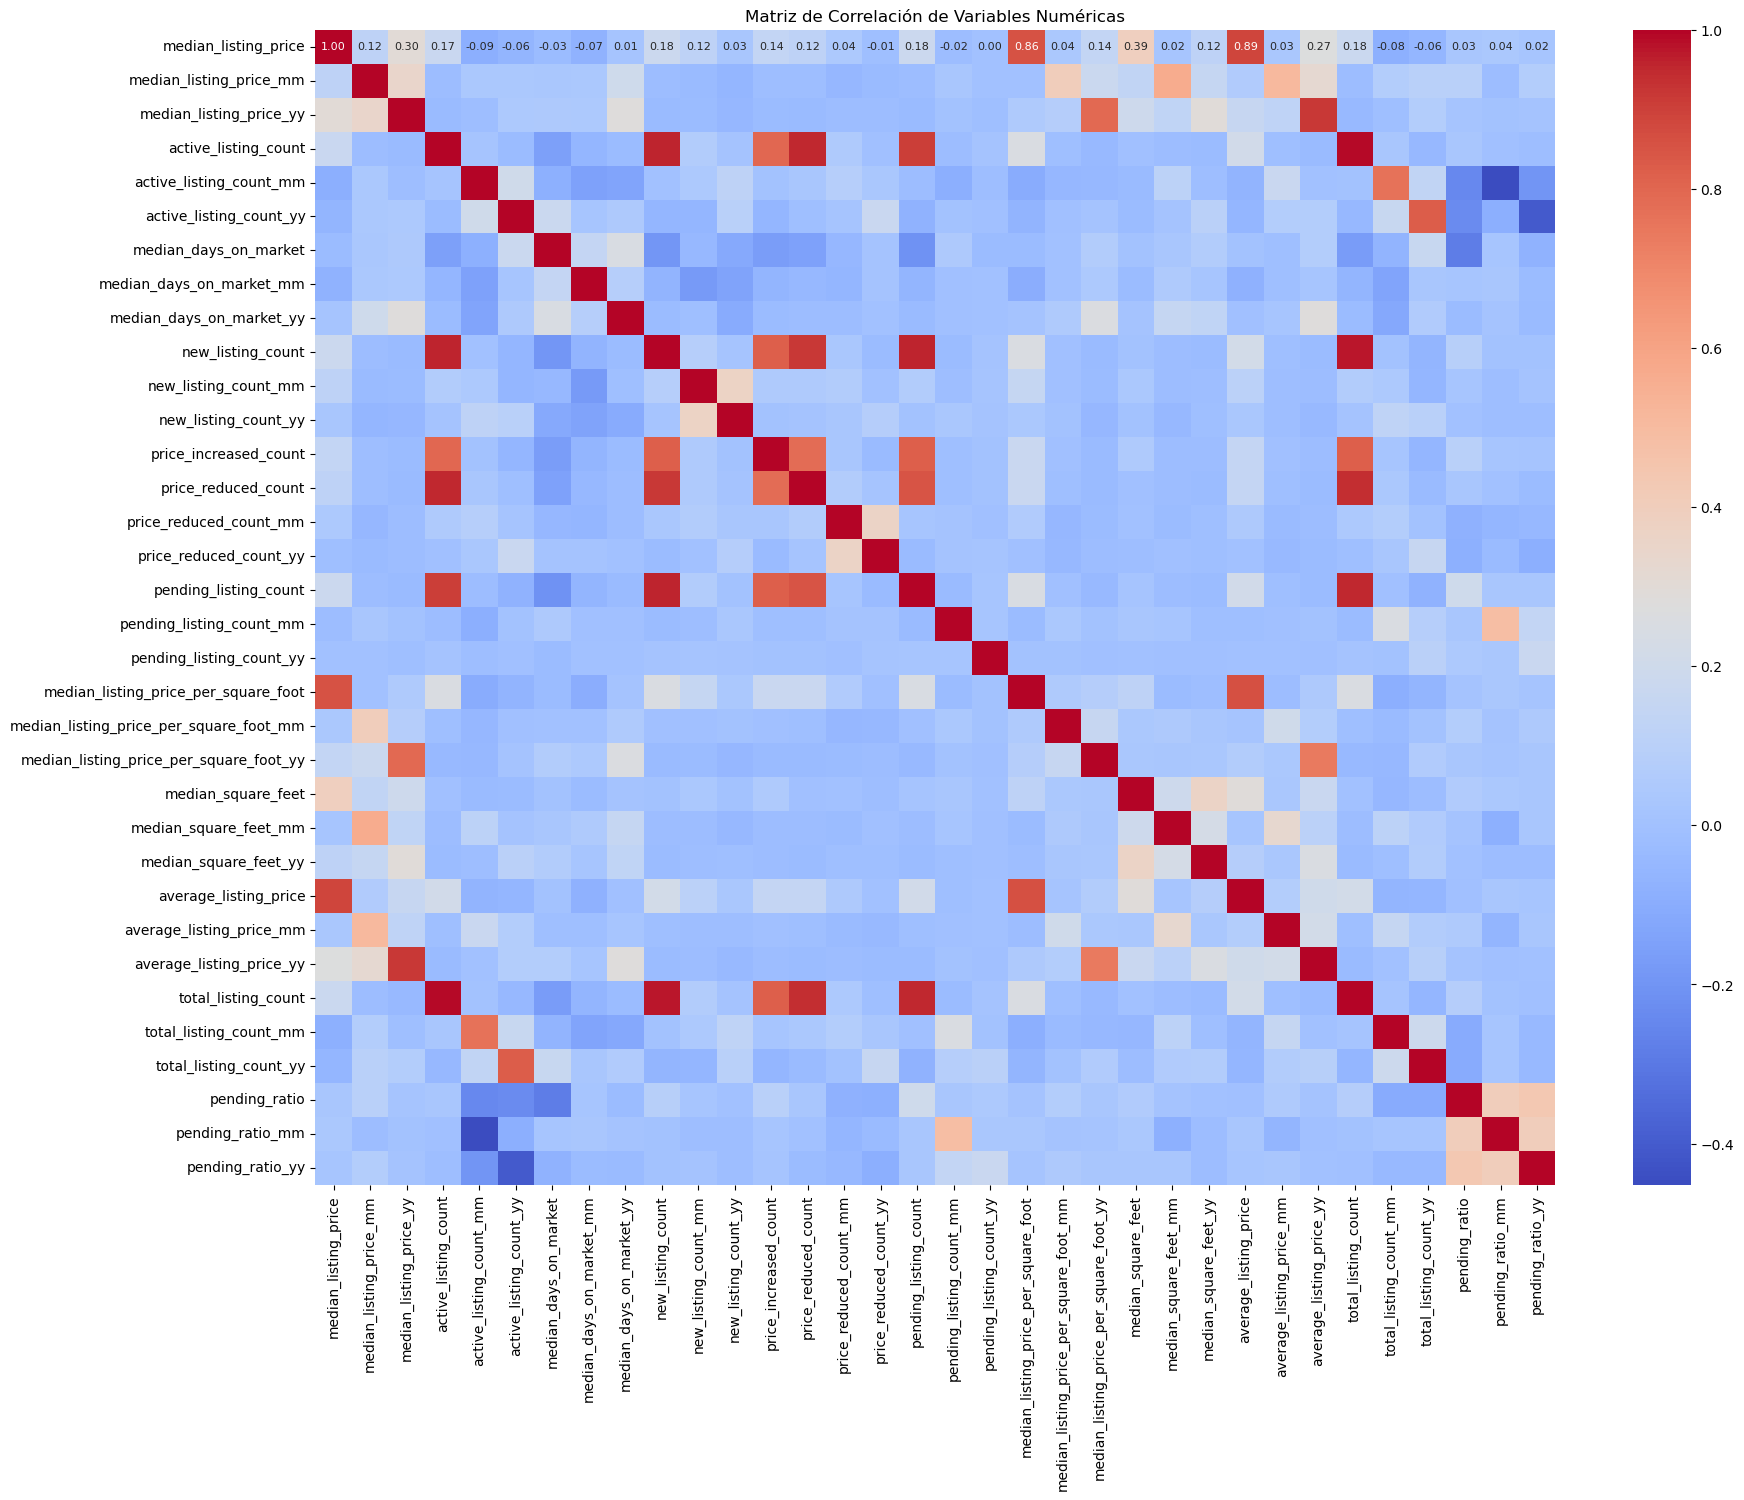

In [157]:
# Selecciona solo columnas numéricas para calcular la matriz de correlación
df_numeric = df_realtor.select_dtypes(include=[np.number])

# Calcula la matriz de correlación
corr_matrix = df_numeric.corr()

# Visualiza la matriz de correlación con números
plt.figure(figsize=(20, 15))  # Ajusta el tamaño según necesites para una mejor visualización
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}) 
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()



In [158]:
df_numeric.corr()

,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,median_days_on_market_yy,new_listing_count,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
median_listing_price,1.000000,0.116901,0.301114,0.168668,-0.092984,-0.060711,-0.031970,-0.074317,0.013947,0.178435,...,0.118107,0.887328,0.033907,0.273885,0.175120,-0.084722,-0.056911,0.026743,0.040537,0.022972
median_listing_price_mm,0.116901,1.000000,0.343374,-0.023302,0.036220,0.040506,0.031852,0.039444,0.194832,-0.021415,...,0.151692,0.060619,0.511088,0.324329,-0.023135,0.072646,0.096898,0.097106,-0.021383,0.074577
median_listing_price_yy,0.301114,0.343374,1.000000,-0.036900,-0.016616,0.042577,0.049144,0.046667,0.280591,-0.034502,...,0.292308,0.159587,0.121821,0.917276,-0.038000,-0.010965,0.070838,0.013729,0.002956,0.013104
active_listing_count,0.168668,-0.023302,-0.036900,1.000000,0.018026,-0.031715,-0.152742,-0.059306,-0.027034,0.955786,...,-0.031600,0.210471,-0.012557,-0.032748,0.991795,0.024709,-0.046735,0.025025,-0.003797,-0.019465
active_listing_count_mm,-0.092984,0.036220,-0.016616,0.018026,1.000000,0.202098,-0.088078,-0.148795,-0.139402,-0.001903,...,-0.016842,-0.070547,0.167267,-0.001751,0.005917,0.763624,0.134408,-0.246214,-0.451691,-0.199894
active_listing_count_yy,-0.060711,0.040506,0.042577,-0.031715,0.202098,1.000000,0.176520,0.023021,0.048381,-0.057403,...,0.098422,-0.058317,0.075387,0.071553,-0.046114,0.165103,0.825371,-0.230642,-0.093665,-0.403288
median_days_on_market,-0.031970,0.031852,0.049144,-0.152742,-0.088078,0.176520,1.000000,0.145565,0.247108,-0.194770,...,0.068232,0.005220,-0.012167,0.073433,-0.173370,-0.070878,0.164831,-0.283043,0.021246,-0.075950
median_days_on_market_mm,-0.074317,0.039444,0.046667,-0.059306,-0.148795,0.023021,0.145565,1.000000,0.085959,-0.070863,...,0.022801,-0.082452,-0.011984,0.024472,-0.061859,-0.138240,0.029919,0.023880,0.027316,-0.028163
median_days_on_market_yy,0.013947,0.194832,0.280591,-0.027034,-0.139402,0.048381,0.247108,0.085959,1.000000,-0.030781,...,0.130547,-0.006703,0.023634,0.283186,-0.029963,-0.119716,0.064096,-0.028328,0.008161,-0.032821
new_listing_count,0.178435,-0.021415,-0.034502,0.955786,-0.001903,-0.057403,-0.194770,-0.070863,-0.030781,1.000000,...,-0.028848,0.217077,-0.010086,-0.029181,0.974756,0.006685,-0.063150,0.092390,0.007602,0.006682


Observamos que:  

**Alta Correlación entre Precio y Área**: Existe una fuerte correlación entre 'median_listing_price' y 'median_listing_price_per_square_foot' (**0.856263**), lo que indica que a medida que aumenta el precio de lista, generalmente también lo hace el precio por pie cuadrado. Esto es de esperar, ya que un precio más alto por lo general refleja una mayor área de la propiedad.

**Relación entre Precio y Precio Promedio**: La correlación entre 'median_listing_price' y 'average_listing_price' es también muy alta (**0.887329**). Esto sugiere que el precio medio y el precio promedio de listado en el mercado tienden a moverse juntos, y ambos pueden ser indicadores del valor general del mercado inmobiliario en un área dada.

**Listados Activos y Nuevos Listados:** La correlación entre 'active_listing_count' y 'new_listing_count' es muy alta (**0.955787**), lo que sugiere que cuando hay más listados activos en el mercado, también hay una tendencia a tener más listados nuevos.

**Cambio Año a Año y Mes a Mes**: Las variables que representan el cambio mes a mes (*_mm) y año a año (*_yy) como 'median_listing_price_mm' y 'median_listing_price_yy' tienen correlaciones significativas entre sí (**0.343375**), lo que podría reflejar tendencias estacionales o anuales en el mercado inmobiliario.

**Relaciones Negativas**: Las variables relacionadas con el ratio pendiente, como 'pending_ratio_mm' y 'pending_ratio_yy', tienen correlaciones negativas con las variables de conteo de listados activos y cambios mes a mes, lo que podría indicar que cuando hay más listados pendientes en proporción a los listados activos, la cantidad de nuevos listados tiende a disminuir.

**Variables Predictivas: Las variables con las correlaciones más altas con el precio de lista, como 'median_listing_price_per_square_foot y average_listing_price, podrían ser buenos predictores para un modelo de precios de vivienda.**


## Visualización de Datos

Visualización de la relación entre precio de listado y precio por m2.

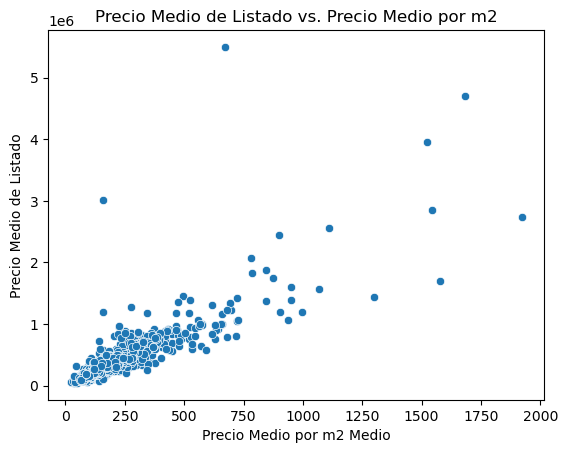

In [159]:
sns.scatterplot(data=df_realtor, x='median_listing_price_per_square_foot', y='median_listing_price')
plt.title('Precio Medio de Listado vs. Precio Medio por m2')
plt.xlabel('Precio Medio por m2 Medio')
plt.ylabel('Precio Medio de Listado')
plt.show()

*Observamos que el mayor grueso de propiedades está entre los 150.000 y 300.000 dolares, y el precio medio de listado es de 180.000 dolares.*

### Visualización de la relación entre precio de listado y precio promedio de listado

En esta visualización quiero ver cómo el precio medio se compara con el precio promedio en el mercado.

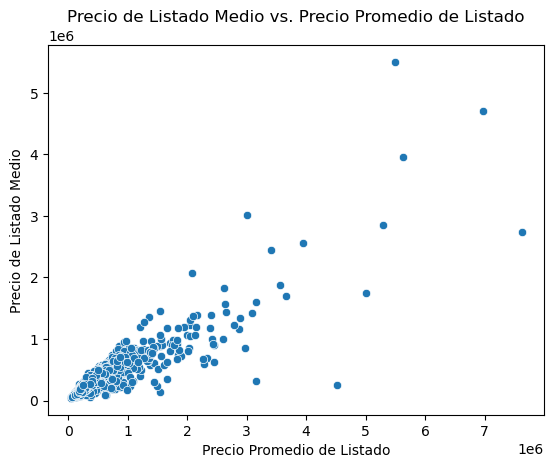

In [160]:
sns.scatterplot(data=df_realtor, x='average_listing_price', y='median_listing_price')
plt.title('Precio de Listado Medio vs. Precio Promedio de Listado')
plt.xlabel('Precio Promedio de Listado')
plt.ylabel('Precio de Listado Medio')
plt.show()

podemos observar que el precio medio de listado está más cerca del precio promedio de listado que el precio medio. 


In [161]:
df_realtor.to_csv('df_realtor.csv')

In [167]:
# Mostrar los primeros 5 registros
df_realtor['county'].head()

0         tripp
1       jackson
2      marshall
3    washington
4        wadena
Name: county, dtype: object

In [168]:
# Mostrar los últimos 5 registros
df_realtor['county'].tail()

3108                 kiowa
3109             petroleum
3110             lafayette
3111                  nome
3112    lake and peninsula
Name: county, dtype: object

Tampoco podemos unir los datasets por ciudad, porque el dataset df_realtor la columna 'county' con condados y no ciudades como tenemos en el df en la columna 'City'.

## Dataset df_California

La solución que he encontrado es, unir el dataset df_california_counties por ciudad con el dataset df, y después unir con county el dataset df_realtor.

In [221]:
df_california_counties = pd.read_csv('California_Incorporated_Cities.csv', encoding='utf-8', sep=',')

In [222]:
df_california_counties.head()

,OBJECTID,COUNTY,CITY,SHAPE_Length,SHAPE_Area
0,1,San Bernardino,Adelanto,122818.299737,2.025272e+08
1,2,Los Angeles,Agoura Hills,29626.940921,2.964318e+07
2,3,Alameda,Alameda,52137.889835,4.358306e+07
3,4,Alameda,Albany,16774.008108,7.558117e+06
4,5,Los Angeles,Alhambra,25461.487721,2.888338e+07


Tenemos un dato muy interesante en este dataframe, y es la longitud y el area de las ciudades. Esto nos puede ser util para nuestro análisis.

In [223]:
df_california_counties.tail()

,OBJECTID,COUNTY,CITY,SHAPE_Length,SHAPE_Area
477,478,Napa,Yountville,18166.776841,6.139924e+06
478,479,Siskiyou,Yreka,64683.192266,4.679887e+07
479,480,Sutter,Yuba City,81828.890218,7.179112e+07
480,481,San Bernardino,Yucaipa,66660.773415,1.068584e+08
481,482,San Bernardino,Yucca Valley,63739.236394,1.509317e+08


In [224]:
df_california_counties.shape

(482, 5)

Comprobamos el número de County y City que tiene el dataframe df_california_counties

In [225]:
df_california_counties['COUNTY'].nunique()

55

In [226]:
df_california_counties['CITY'].nunique()

482

In [227]:
df_california_counties['COUNTY'].count()

482

In [228]:
df_california_counties['CITY'].count()

482

Comprobamos el total de filas de la columna City de nuestro dataset principal. 

In [229]:
df['City'].count()

323

In [230]:
df['City'].nunique()

134

### 1. Limpieza y Consistencia de los Datos

In [231]:
# Convertir a mayúsculas y eliminar espacios al inicio y al final
df['City'] = df['City'].str.upper().str.strip()
df_california_counties['CITY'] = df_california_counties['CITY'].str.upper().str.strip()

# Para un tratamiento más avanzado de acentos, se puede usar la librería `unidecode`

# Aplicar unidecode para remover acentos
df['City'] = df['City'].apply(unidecode)
df_california_counties['CITY'] = df_california_counties['CITY'].apply(unidecode)


### Eliminamos la columna OBJECTID

In [232]:
df_california_counties = df_california_counties.drop(columns=['OBJECTID'])


In [233]:
df['City'].unique()

array(['SAN FRANCISCO', 'LODI', 'STOCKTON', 'PISMO BEACH', 'MONTEREY',
       'PASO ROBLES', 'ATASCADERO', 'ARROYO GRANDE', 'MORRO BAY',
       'SOUTH SAN FRANCISCO', 'SAN MATEO', 'REDWOOD CITY', 'FAIRFIELD',
       'VALLEJO', 'VACAVILLE', 'SEBASTOPOL', 'SANTA ROSA', 'WINDSOR',
       'CARPINTERIA', 'SANTA BARBARA', 'LOMPOC', 'SANTA MARIA', 'WEED',
       'NEWMAN', 'MODESTO', 'TURLOCK', 'YUBA CITY', 'SANTA CRUZ',
       'WATSONVILLE', 'RED BLUFF', 'TUOLUMNE', 'DINUBA', 'VISALIA',
       'PORTERVILLE', 'TULARE', 'VENTURA', 'CAMARILLO', 'PORT HUENEME',
       'OXNARD', 'MOORPARK', 'THOUSAND OAKS', 'SIMI VALLEY', 'SAN DIEGO',
       'OCEANSIDE', 'CARLSBAD', 'VISTA', 'SAN MARCOS', 'POWAY', 'SANTEE',
       'EL CAJON', 'RIALTO', 'SAN BERNARDINO', 'HESPERIA', 'MONTCLAIR',
       'CHINO HILLS', 'UPLAND', 'FONTANA', 'BIG BEAR LAKE', 'COLFAX',
       'AUBURN', 'PLACER', 'ROCKLIN', 'ROSEVILLE', 'RIVERSIDE',
       'MORENO VALLEY', 'LAKE ELSINORE', 'BEAUMONT', 'SAN JACINTO',
       'HEMET', 'RANC

In [234]:
df_california_counties['CITY'].unique()

array(['ADELANTO', 'AGOURA HILLS', 'ALAMEDA', 'ALBANY', 'ALHAMBRA',
       'ALISO VIEJO', 'ALTURAS', 'AMADOR CITY', 'AMERICAN CANYON',
       'ANAHEIM', 'ANDERSON', 'ANGELS', 'ANTIOCH', 'APPLE VALLEY',
       'ARCADIA', 'ARCATA', 'ARROYO GRANDE', 'ARTESIA', 'ARVIN',
       'ATASCADERO', 'ATHERTON', 'ATWATER', 'AUBURN', 'AVALON', 'AVENAL',
       'AZUSA', 'BAKERSFIELD', 'BALDWIN PARK', 'BANNING', 'BARSTOW',
       'BEAUMONT', 'BELL', 'BELL GARDENS', 'BELLFLOWER', 'BELMONT',
       'BELVEDERE', 'BENICIA', 'BERKELEY', 'BEVERLY HILLS',
       'BIG BEAR LAKE', 'BIGGS', 'BISHOP', 'BLUE LAKE', 'BLYTHE',
       'BRADBURY', 'BRAWLEY', 'BREA', 'BRENTWOOD', 'BRISBANE', 'BUELLTON',
       'BUENA PARK', 'BURBANK', 'BURLINGAME', 'CALABASAS', 'CALEXICO',
       'CALIFORNIA', 'CALIMESA', 'CALIPATRIA', 'CALISTOGA', 'CAMARILLO',
       'CAMPBELL', 'CANYON LAKE', 'CAPITOLA', 'CARLSBAD',
       'CARMEL-BY-THE-SEA', 'CARPINTERIA', 'CARSON', 'CATHEDRAL CITY',
       'CERES', 'CERRITOS', 'CHICO', 'CHINO', 'C

### Unión Dataframes df y df_california_counties a través de City
donde se cargarán los nombres de los condados, para unir el tercer dataframe df_realtor.

1. Hacemos Marge con df y df_california_countries a través de las columnas Ciudad. Pero primero vamos a usar str.lower() para convertir a minúsculas, str.strip() para eliminar espacios en blanco adicionales, y verificar la consistencia de los datos. Así nos aseguramos de que los valores de las columnas sean consistentes en ambos Dataframes.

In [246]:
# Convertir a mayúsculas y eliminar espacios al inicio y al final
df['City'] = df['City'].str.upper().str.strip()
df_california_counties['CITY'] = df_california_counties['CITY'].str.upper().str.strip()

# Para un tratamiento más avanzado de acentos, se puede usar la librería `unidecode`

# Aplicar unidecode para remover acentos
df['City'] = df['City'].apply(unidecode)
df_california_counties['CITY'] = df_california_counties['CITY'].apply(unidecode)


2. Para conservar todas las filas del DataFrame de la izquierda (df) y llenar con NaN las columnas del DataFrame de la derecha (df_california_counties) paralas filas donde no haya coincidencia, utilizarmeso left join.

In [247]:
df_merged = pd.merge(df, df_california_counties, left_on='City', right_on='CITY', how='left')
# Esto realiza un left join, manteniendo solo las filas que tienen correspondencia en ambas columnas,

In [248]:
df_merged

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,is_in_county_fips,is_in_county_name,COUNTY,CITY,SHAPE_Length,SHAPE_Area
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,94115,0,False,False,San Francisco,SAN FRANCISCO,78294.793713,2.188028e+08
1,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,94118,0,False,False,San Francisco,SAN FRANCISCO,78294.793713,2.188028e+08
2,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,94116,0,False,False,San Francisco,SAN FRANCISCO,78294.793713,2.188028e+08
3,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,94116,0,False,False,San Francisco,SAN FRANCISCO,78294.793713,2.188028e+08
4,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,94114,0,False,False,San Francisco,SAN FRANCISCO,78294.793713,2.188028e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,90275,0,False,False,Los Angeles,RANCHO PALOS VERDES,75838.372826,5.071580e+07
319,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,90275,0,False,False,Los Angeles,RANCHO PALOS VERDES,75838.372826,5.071580e+07
320,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,90638,0,False,False,Los Angeles,LA MIRADA,29339.414247,2.956609e+07
321,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,90603,0,False,False,Los Angeles,WHITTIER,60122.342762,5.533268e+07


Revisar las ciudades que no encontraron coincidencia

In [249]:
#Revisar las ciudades que no encontraron coincidencia
ciudades_sin_coincidencia = df_merged[df_merged['CITY'].isna()]['City'].unique()
print("Ciudades sin coincidencia:", ciudades_sin_coincidencia)

Ciudades sin coincidencia: ['TUOLUMNE' 'PLACER' 'BUTTE' 'CONTRA COSTA' 'EL DORADO']


In [252]:
df_merged[df_merged.CITY=='BRADLEY']

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,is_in_county_fips,is_in_county_name,COUNTY,CITY,SHAPE_Length,SHAPE_Area


A continuación voy a realizar un mapeo manual de las  44 ciudades que averiguar cuál es su condado. y después realizar el merge.

In [264]:
# Actualización del mapeo manual con la nueva información
correcciones_ciudades = {
'TUOLUMNE':'MI WUK VILLAGE', 'PLACER': 'OLYMPIC VALLEY', 'BUTTE':'MAGALIA', 'BUTTE':'CLIPPER MILLS', 'CONTRA COSTA':'DISCOVERY BAY', 'EL DORADO':'GRIZZLY FLATS', 
}
# Aplicar correcciones
df_merged['COUNTY'] = df_merged['City'].apply(lambda x: correcciones_ciudades.get(x, x)).values

# Preparar para eliminar 'groveland' si está presente
#df_merged = df_merged[df_merged['City'].str.lower() != 'groveland']

Vamos a verificar que el proceso de merge y la asignación de las ciudades se ha realizado correctamente. 

In [265]:
df_merged[df_merged.City=='PLACER']

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,is_in_county_fips,is_in_county_name,COUNTY,CITY,SHAPE_Length,SHAPE_Area
148,2350000.0,5,6,2853.0,162 Tiger Tail Rd,PLACER,96146,0,False,True,OLYMPIC VALLEY,NaN,NaN,NaN
208,710000.0,3,2,2468.0,50942 Conifer Dr,PLACER,95728,0,False,True,OLYMPIC VALLEY,NaN,NaN,NaN


In [266]:
#Revisar las CONDADO que no encontraron coincidencia
counties_sin_coincidencia = df_merged[df_merged['COUNTY'].isna()]['City'].unique()
print("Counties sin coincidencia:", counties_sin_coincidencia)

Counties sin coincidencia: []


1. Revisamos el número de Filas Antes y después del Merge

In [267]:
print(f"Filas en df original: {df.shape[0]}")
print(f"Filas después del merge: {df_merged.shape[0]}")


Filas en df original: 323
Filas después del merge: 323


2. Revisión de valores NaN

In [268]:
print(df_merged.isna().sum())


Price                0
Beds                 0
Baths                0
Square Feet          0
Street               0
City                 0
Zip                  0
Toilets              0
is_in_county_fips    0
is_in_county_name    0
COUNTY               0
CITY                 9
SHAPE_Length         9
SHAPE_Area           9
dtype: int64


3. Verificamos que en todas las columnas existan 324 valores.

In [269]:
df_merged.count()

Price                323
Beds                 323
Baths                323
Square Feet          323
Street               323
City                 323
Zip                  323
Toilets              323
is_in_county_fips    323
is_in_county_name    323
COUNTY               323
CITY                 314
SHAPE_Length         314
SHAPE_Area           314
dtype: int64

In [270]:
df_merged.drop(['CITY','SHAPE_Length','SHAPE_Area','is_in_county_fips','is_in_county_name'], axis=1, inplace= True)

In [271]:
df_merged

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,COUNTY
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,94115,0,SAN FRANCISCO
1,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,94118,0,SAN FRANCISCO
2,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,94116,0,SAN FRANCISCO
3,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,94116,0,SAN FRANCISCO
4,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,94114,0,SAN FRANCISCO
...,...,...,...,...,...,...,...,...,...
318,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,90275,0,RANCHO PALOS VERDES
319,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,90275,0,RANCHO PALOS VERDES
320,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,90638,0,LA MIRADA
321,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,90603,0,WHITTIER


In [272]:
df_merged.to_csv('df_merged.csv')

# Merged() df_merged y df_realtor

In [273]:
# importar df pricipal
df_final= pd.read_csv('df_merged.csv', encoding='utf-8', sep=',')

In [274]:

# importar df realtor 
df_final_realtor= pd.read_csv('df_realtor.csv', encoding='utf-8', sep=',')

In [275]:
df_final.head(10)

,Unnamed: 0,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,COUNTY
0,0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,94115,0,SAN FRANCISCO
1,1,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,94118,0,SAN FRANCISCO
2,2,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,94116,0,SAN FRANCISCO
3,3,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,94116,0,SAN FRANCISCO
4,4,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,94114,0,SAN FRANCISCO
5,5,1450000.0,5,4,2024.0,195 Ledyard St,SAN FRANCISCO,94124,0,SAN FRANCISCO
6,6,950000.0,4,1,1375.0,229 Winfield St,SAN FRANCISCO,94110,0,SAN FRANCISCO
7,7,1210000.0,2,2,1200.0,78 Niagara Ave,SAN FRANCISCO,94112,0,SAN FRANCISCO
8,8,2050000.0,3,3,2200.0,800 Junipero Serra Blvd,SAN FRANCISCO,94127,0,SAN FRANCISCO
9,9,1460000.0,3,3,1900.0,65 Digby St,SAN FRANCISCO,94131,0,SAN FRANCISCO


In [276]:
df_final_realtor.head(10)

,Unnamed: 0,county_fips,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,county
0,0,46123,257500.0,0.0510,0.0300,4.0,-0.2000,-0.6190,110.0,0.4253,...,4516288.0,0.2389,1.4495,6.0,0.0000,-0.4783,0.5000,0.3000,0.4048,tripp
1,1,8057,718750.0,0.3690,0.0636,6.0,-0.1429,2.0000,145.0,-0.0350,...,1560357.0,0.0740,1.3091,7.0,-0.0714,0.6250,0.1667,0.0238,-0.8333,jackson
2,2,47117,370875.0,-0.0084,0.1154,116.0,-0.1145,-0.0128,74.0,0.1308,...,507072.0,-0.0038,0.0459,139.0,-0.1146,-0.0211,0.1940,-0.0121,-0.0528,marshall
3,3,5143,398468.0,0.0088,-0.0123,569.0,-0.0741,0.1071,76.0,0.1103,...,522550.0,0.0082,-0.0180,931.0,-0.0553,0.0065,0.6482,0.0391,-0.1541,washington
4,4,27159,237425.0,-0.0103,0.0731,38.0,-0.1163,0.5200,103.0,0.0868,...,277465.0,0.0001,0.1770,52.0,-0.0714,0.4444,0.3816,0.0560,-0.0584,wadena
5,5,37037,850000.0,0.0000,0.0904,201.0,-0.1027,-0.1027,86.0,-0.0284,...,1106520.0,0.0656,0.1381,360.0,-0.0476,-0.1499,0.7960,0.1219,-0.0879,chatham
6,6,13269,94750.0,0.2147,-0.1689,5.0,-0.1000,0.1250,112.0,0.2816,...,210510.0,0.1523,0.2493,6.0,-0.1429,0.2000,0.2222,-0.1778,-0.1528,taylor
7,7,19161,217100.0,0.1313,0.4136,26.0,-0.0556,0.3077,90.0,0.1424,...,272596.0,0.0377,0.3974,32.0,-0.0156,-0.0308,0.2353,0.0501,-0.4314,sac
8,8,13275,333675.0,-0.0038,0.1716,125.0,-0.0040,0.3037,77.0,0.0405,...,409999.0,-0.0202,0.0728,157.0,0.0000,0.2460,0.2651,-0.0149,-0.0805,thomas
9,9,55029,524900.0,-0.0187,-0.2031,220.0,-0.0909,0.4426,137.0,0.1417,...,596511.0,-0.0304,-0.2825,279.0,-0.0762,0.3037,0.2795,0.0233,-0.1303,door


Tenemos que convertir la columna County a mayúsculas

In [277]:
# Convertir a mayúsculas y eliminar espacios al inicio y al final
df_final_realtor['county'] = df_final_realtor['county'].str.upper().str.strip()

# Para un tratamiento más avanzado de acentos, se puede usar la librería `unidecode`

# Aplicar unidecode para remover acentos
df_final_realtor['county'] = df_final_realtor['county'].apply(unidecode)


In [278]:
df_final_realtor

,Unnamed: 0,county_fips,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,county
0,0,46123,257500.0,0.0510,0.0300,4.0,-0.2000,-0.6190,110.0,0.4253,...,4516288.0,0.2389,1.4495,6.0,0.0000,-0.4783,0.5000,0.3000,0.40480,TRIPP
1,1,8057,718750.0,0.3690,0.0636,6.0,-0.1429,2.0000,145.0,-0.0350,...,1560357.0,0.0740,1.3091,7.0,-0.0714,0.6250,0.1667,0.0238,-0.83330,JACKSON
2,2,47117,370875.0,-0.0084,0.1154,116.0,-0.1145,-0.0128,74.0,0.1308,...,507072.0,-0.0038,0.0459,139.0,-0.1146,-0.0211,0.1940,-0.0121,-0.05280,MARSHALL
3,3,5143,398468.0,0.0088,-0.0123,569.0,-0.0741,0.1071,76.0,0.1103,...,522550.0,0.0082,-0.0180,931.0,-0.0553,0.0065,0.6482,0.0391,-0.15410,WASHINGTON
4,4,27159,237425.0,-0.0103,0.0731,38.0,-0.1163,0.5200,103.0,0.0868,...,277465.0,0.0001,0.1770,52.0,-0.0714,0.4444,0.3816,0.0560,-0.05840,WADENA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,3108,20097,274999.0,0.2500,3.5910,1.0,-0.6667,0.0000,83.0,0.1458,...,274999.0,0.4474,3.5910,2.0,-0.3333,1.0000,1.0000,0.0176,0.50000,KIOWA
3109,3109,30069,310000.0,0.0000,-0.1842,6.0,0.0000,1.0000,124.0,0.1923,...,399871.0,0.2406,0.0523,8.0,0.2500,1.5000,0.2500,0.0176,-0.01985,PETROLEUM
3110,3110,5073,272625.0,0.5534,1.0614,11.0,0.0000,4.5000,138.0,0.2972,...,372028.0,0.0865,1.8131,12.0,0.0909,5.0000,0.0909,0.0176,-0.01985,LAFAYETTE
3111,3111,2180,257500.0,-0.0077,-0.5522,2.0,-0.5000,1.0000,110.0,-0.1852,...,257500.0,-0.0039,-0.5522,2.0,-0.5000,1.0000,0.3852,0.0176,-0.01985,NOME


In [280]:
#hacer comprobaciones 
df_final_realtor[df_final_realtor.county=='SAN FRANCISCO']

,Unnamed: 0,county_fips,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,county
1843,1843,6075,1198700.0,-0.0011,-0.0736,667.0,-0.1449,-0.0206,65.0,-0.1835,...,1939987.0,-0.0536,-0.0655,847.0,-0.1856,-0.0208,0.2864,-0.0521,-0.0059,SAN FRANCISCO


In [320]:
df_final_realtor

,Unnamed: 0,county_fips,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,county
0,0,46123,257500.0,0.0510,0.0300,4.0,-0.2000,-0.6190,110.0,0.4253,...,4516288.0,0.2389,1.4495,6.0,0.0000,-0.4783,0.5000,0.3000,0.40480,TRIPP
1,1,8057,718750.0,0.3690,0.0636,6.0,-0.1429,2.0000,145.0,-0.0350,...,1560357.0,0.0740,1.3091,7.0,-0.0714,0.6250,0.1667,0.0238,-0.83330,JACKSON
2,2,47117,370875.0,-0.0084,0.1154,116.0,-0.1145,-0.0128,74.0,0.1308,...,507072.0,-0.0038,0.0459,139.0,-0.1146,-0.0211,0.1940,-0.0121,-0.05280,MARSHALL
3,3,5143,398468.0,0.0088,-0.0123,569.0,-0.0741,0.1071,76.0,0.1103,...,522550.0,0.0082,-0.0180,931.0,-0.0553,0.0065,0.6482,0.0391,-0.15410,WASHINGTON
4,4,27159,237425.0,-0.0103,0.0731,38.0,-0.1163,0.5200,103.0,0.0868,...,277465.0,0.0001,0.1770,52.0,-0.0714,0.4444,0.3816,0.0560,-0.05840,WADENA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,3108,20097,274999.0,0.2500,3.5910,1.0,-0.6667,0.0000,83.0,0.1458,...,274999.0,0.4474,3.5910,2.0,-0.3333,1.0000,1.0000,0.0176,0.50000,KIOWA
3109,3109,30069,310000.0,0.0000,-0.1842,6.0,0.0000,1.0000,124.0,0.1923,...,399871.0,0.2406,0.0523,8.0,0.2500,1.5000,0.2500,0.0176,-0.01985,PETROLEUM
3110,3110,5073,272625.0,0.5534,1.0614,11.0,0.0000,4.5000,138.0,0.2972,...,372028.0,0.0865,1.8131,12.0,0.0909,5.0000,0.0909,0.0176,-0.01985,LAFAYETTE
3111,3111,2180,257500.0,-0.0077,-0.5522,2.0,-0.5000,1.0000,110.0,-0.1852,...,257500.0,-0.0039,-0.5522,2.0,-0.5000,1.0000,0.3852,0.0176,-0.01985,NOME


In [322]:
df_bueno= pd.merge(df_final, df_final_realtor[['median_listing_price','county']], left_on='COUNTY', right_on='county', how='left')

In [323]:
df_bueno

,Unnamed: 0,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,COUNTY,median_listing_price,county
0,0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,94115,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
1,1,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,94118,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
2,2,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,94116,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
3,3,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,94116,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
4,4,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,94114,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
...,...,...,...,...,...,...,...,...,...,...,...,...
341,318,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,90275,0,RANCHO PALOS VERDES,NaN,NaN
342,319,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,90275,0,RANCHO PALOS VERDES,NaN,NaN
343,320,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,90638,0,LA MIRADA,NaN,NaN
344,321,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,90603,0,WHITTIER,NaN,NaN


In [328]:
df_bueno[df_bueno['Unnamed: 0'].duplicated()]

,Unnamed: 0,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,COUNTY,median_listing_price,county
33,32,910000.0,4,3,2080.0,5145 Mono Ct,FAIRFIELD,94534,0,FAIRFIELD,805950.0,FAIRFIELD
34,32,910000.0,4,3,2080.0,5145 Mono Ct,FAIRFIELD,94534,0,FAIRFIELD,232000.0,FAIRFIELD
36,33,535000.0,3,2,1532.0,2275 Cambridge Dr,FAIRFIELD,94533,0,FAIRFIELD,805950.0,FAIRFIELD
37,33,535000.0,3,2,1532.0,2275 Cambridge Dr,FAIRFIELD,94533,0,FAIRFIELD,232000.0,FAIRFIELD
45,40,655000.0,4,3,1942.0,1482 Driftwood Cir,FAIRFIELD,94534,0,FAIRFIELD,805950.0,FAIRFIELD
46,40,655000.0,4,3,1942.0,1482 Driftwood Cir,FAIRFIELD,94534,0,FAIRFIELD,232000.0,FAIRFIELD
73,66,575000.0,1,1,1028.0,318 Soquel Ave UNIT A3,SANTA CRUZ,95062,0,SANTA CRUZ,1062000.0,SANTA CRUZ
75,67,1480000.0,3,2,1693.0,179 Ramada Ln,SANTA CRUZ,95003,0,SANTA CRUZ,1062000.0,SANTA CRUZ
77,68,1410000.0,3,2,1593.0,205 Sand St,SANTA CRUZ,95003,0,SANTA CRUZ,1062000.0,SANTA CRUZ
156,146,420000.0,3,2,1058.0,131 W Oak St,COLFAX,95713,0,COLFAX,365500.0,COLFAX


In [331]:
df_bueno.drop(columns=['Zip'],inplace=True)

In [332]:
df_bueno

,Unnamed: 0,Price,Beds,Baths,Square Feet,Street,City,Toilets,COUNTY,median_listing_price,county
0,0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
1,1,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
2,2,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
3,3,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
4,4,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
...,...,...,...,...,...,...,...,...,...,...,...
341,318,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,0,RANCHO PALOS VERDES,NaN,NaN
342,319,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,0,RANCHO PALOS VERDES,NaN,NaN
343,320,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,0,LA MIRADA,NaN,NaN
344,321,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,0,WHITTIER,NaN,NaN


In [334]:
# Identificar los duplicados en 'Unnamed: 0'
duplicados = df_bueno['Unnamed: 0'].duplicated(keep=False)  # keep=False marca todos los duplicados como True

# Calcular las medias de 'median_listing_price' para cada grupo de valores duplicados en 'Unnamed: 0'
medias = df_bueno[duplicados].groupby('Unnamed: 0')['median_listing_price'].transform('mean')

# Asignar las medias calculadas a la columna 'median_listing_price' en las filas duplicadas
df_bueno.loc[duplicados, 'median_listing_price'] = medias

In [338]:
df_bueno[df_bueno['Unnamed: 0'].duplicated()]

,Unnamed: 0,Price,Beds,Baths,Square Feet,Street,City,Toilets,COUNTY,median_listing_price,county
33,32,910000.0,4,3,2080.0,5145 Mono Ct,FAIRFIELD,0,FAIRFIELD,468716.666667,FAIRFIELD
34,32,910000.0,4,3,2080.0,5145 Mono Ct,FAIRFIELD,0,FAIRFIELD,468716.666667,FAIRFIELD
36,33,535000.0,3,2,1532.0,2275 Cambridge Dr,FAIRFIELD,0,FAIRFIELD,468716.666667,FAIRFIELD
37,33,535000.0,3,2,1532.0,2275 Cambridge Dr,FAIRFIELD,0,FAIRFIELD,468716.666667,FAIRFIELD
45,40,655000.0,4,3,1942.0,1482 Driftwood Cir,FAIRFIELD,0,FAIRFIELD,468716.666667,FAIRFIELD
46,40,655000.0,4,3,1942.0,1482 Driftwood Cir,FAIRFIELD,0,FAIRFIELD,468716.666667,FAIRFIELD
73,66,575000.0,1,1,1028.0,318 Soquel Ave UNIT A3,SANTA CRUZ,0,SANTA CRUZ,716987.500000,SANTA CRUZ
75,67,1480000.0,3,2,1693.0,179 Ramada Ln,SANTA CRUZ,0,SANTA CRUZ,716987.500000,SANTA CRUZ
77,68,1410000.0,3,2,1593.0,205 Sand St,SANTA CRUZ,0,SANTA CRUZ,716987.500000,SANTA CRUZ
156,146,420000.0,3,2,1058.0,131 W Oak St,COLFAX,0,COLFAX,320250.000000,COLFAX


In [342]:
df_bueno.drop_duplicates(inplace=True)

In [343]:
df_bueno.isnull().sum()

Unnamed: 0                0
Price                     0
Beds                      0
Baths                     0
Square Feet               0
Street                    0
City                      0
Toilets                   0
COUNTY                    0
median_listing_price    190
county                  190
dtype: int64

In [303]:
#Revisamos cuantas county
df_bueno['county']. nunique()

25

In [304]:
df_bueno['county'].count()

156

In [305]:
df_bueno['county']

0      SAN FRANCISCO
1      SAN FRANCISCO
2      SAN FRANCISCO
3      SAN FRANCISCO
4      SAN FRANCISCO
           ...      
341              NaN
342              NaN
343              NaN
344              NaN
345              NaN
Name: county, Length: 346, dtype: object

In [306]:
df_bueno['county'].duplicated().sum() 

320

In [307]:
df_bueno['county'].value_counts()

county
LOS ANGELES       45
SAN DIEGO         27
LANCASTER         12
SAN FRANCISCO     10
FAIRFIELD          9
SAN MATEO          7
SAN BERNARDINO     7
SANTA CRUZ         6
FRESNO             4
RICHMOND           4
SANTA ROSA         3
RIVERSIDE          3
CLAYTON            2
PALO ALTO          2
COLFAX             2
VENTURA            2
SANTA BARBARA      2
WINDSOR            2
PITTSBURG          1
SAN JACINTO        1
MONTEREY           1
TULARE             1
SANTA CLARA        1
CARSON             1
TORRANCE           1
Name: count, dtype: int64

In [308]:
df_bueno[df_bueno.county=='RIVERSIDE']

,Unnamed: 0_x,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,COUNTY,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,county
162,152,625000.0,3,2,1294.0,6741 Huntsman St,RIVERSIDE,92509,0,RIVERSIDE,...,943348.0,0.0373,0.1075,6852.0,-0.034,-0.0474,0.5334,0.0226,0.1037,RIVERSIDE
163,153,915000.0,3,2,1866.0,2141 Saint Lawrence St,RIVERSIDE,92504,0,RIVERSIDE,...,943348.0,0.0373,0.1075,6852.0,-0.034,-0.0474,0.5334,0.0226,0.1037,RIVERSIDE
167,157,800000.0,4,3,2400.0,22882 Giant Fir Pl,RIVERSIDE,92587,0,RIVERSIDE,...,943348.0,0.0373,0.1075,6852.0,-0.034,-0.0474,0.5334,0.0226,0.1037,RIVERSIDE


In [302]:
#muestrame el codigo Los county si  tenga valores en median_listing_price
df_final_realtor.dropna(subset=['median_listing_price'])['county'].value_counts()

county
WASHINGTON            31
JEFFERSON             26
FRANKLIN              25
LINCOLN               24
JACKSON               23
                      ..
KOOCHICHING            1
BELTRAMI               1
BUREAU                 1
PIPESTONE              1
LAKE AND PENINSULA     1
Name: count, Length: 1832, dtype: int64

In [310]:
df_final['COUNTY'].value_counts()

COUNTY
LOS ANGELES      45
SAN DIEGO        27
SAN JOSE         11
SAN FRANCISCO    10
LONG BEACH        7
                 ..
MONTCLAIR         1
RIALTO            1
SANTEE            1
SAN MARCOS        1
CLAREMONT         1
Name: count, Length: 134, dtype: int64

In [317]:
df_bueno['COUNTY'].value_counts().sort_index()

COUNTY
ALHAMBRA            1
ARCADIA             1
ARROYO GRANDE       1
ATASCADERO          3
AUBURN              1
                   ..
WEST HOLLYWOOD      1
WESTLAKE VILLAGE    1
WHITTIER            1
WINDSOR             2
YUBA CITY           1
Name: count, Length: 134, dtype: int64

Aquí solo me suma 156 

In [314]:
df_final['COUNTY'].value_counts().sort_index()

COUNTY
ALHAMBRA            1
ARCADIA             1
ARROYO GRANDE       1
ATASCADERO          3
AUBURN              1
                   ..
WEST HOLLYWOOD      1
WESTLAKE VILLAGE    1
WHITTIER            1
WINDSOR             2
YUBA CITY           1
Name: count, Length: 134, dtype: int64

In [316]:
df_final.dropna()

,Unnamed: 0,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,COUNTY
0,0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,94115,0,SAN FRANCISCO
1,1,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,94118,0,SAN FRANCISCO
2,2,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,94116,0,SAN FRANCISCO
3,3,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,94116,0,SAN FRANCISCO
4,4,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,94114,0,SAN FRANCISCO
...,...,...,...,...,...,...,...,...,...,...
318,318,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,90275,0,RANCHO PALOS VERDES
319,319,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,90275,0,RANCHO PALOS VERDES
320,320,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,90638,0,LA MIRADA
321,321,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,90603,0,WHITTIER


In [348]:
df_bueno

,Unnamed: 0,Price,Beds,Baths,Square Feet,Street,City,Toilets,COUNTY,median_listing_price,county
0,0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
1,1,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
2,2,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
3,3,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
4,4,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,0,SAN FRANCISCO,1198700.0,SAN FRANCISCO
...,...,...,...,...,...,...,...,...,...,...,...
341,318,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,0,RANCHO PALOS VERDES,NaN,NaN
342,319,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,0,RANCHO PALOS VERDES,NaN,NaN
343,320,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,0,LA MIRADA,NaN,NaN
344,321,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,0,WHITTIER,NaN,NaN


In [350]:
#Revisar las CONDADO que no encontraron coincidencia
df_countis_sin_coincidencia = df_bueno[df_bueno['county'].isna()]['COUNTY'].unique()
print("Counties sin coincidencia:", df_countis_sin_coincidencia)

Counties sin coincidencia: ['LODI' 'STOCKTON' 'PISMO BEACH' 'PASO ROBLES' 'ATASCADERO'
 'ARROYO GRANDE' 'MORRO BAY' 'SOUTH SAN FRANCISCO' 'REDWOOD CITY'
 'VALLEJO' 'VACAVILLE' 'SEBASTOPOL' 'CARPINTERIA' 'LOMPOC' 'SANTA MARIA'
 'WEED' 'NEWMAN' 'MODESTO' 'TURLOCK' 'YUBA CITY' 'WATSONVILLE' 'RED BLUFF'
 'MI WUK VILLAGE' 'DINUBA' 'VISALIA' 'PORTERVILLE' 'CAMARILLO'
 'PORT HUENEME' 'OXNARD' 'MOORPARK' 'THOUSAND OAKS' 'SIMI VALLEY'
 'OCEANSIDE' 'CARLSBAD' 'VISTA' 'SAN MARCOS' 'POWAY' 'SANTEE' 'EL CAJON'
 'RIALTO' 'HESPERIA' 'MONTCLAIR' 'CHINO HILLS' 'UPLAND' 'FONTANA'
 'BIG BEAR LAKE' 'AUBURN' 'OLYMPIC VALLEY' 'ROCKLIN' 'ROSEVILLE'
 'MORENO VALLEY' 'LAKE ELSINORE' 'BEAUMONT' 'HEMET' 'RANCHO MIRAGE'
 'PALM DESERT' 'INDIAN WELLS' 'DESERT HOT SPRINGS' 'CATHEDRAL CITY'
 'TEMECULA' 'MURRIETA' 'OROVILLE' 'PARADISE' 'CLIPPER MILLS'
 'DISCOVERY BAY' 'CONCORD' 'WALNUT CREEK' 'PLEASANT HILL' 'EL CERRITO'
 'GRIZZLY FLATS' 'SELMA' 'REEDLEY' 'GRASS VALLEY' 'TRUCKEE' 'NEVADA CITY'
 'MILPITAS' 'SUNNYVALE' 

In [353]:
df_final_realtor[df_final_realtor.county=='LODI']

,Unnamed: 0,county_fips,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,county


In [355]:
# Paso 1: Encuentra la media de 'Price' por 'COUNTY'
media_price_por_county = df_bueno.groupby('COUNTY')['Price'].mean()

# Paso 2: Rellena los valores NaN en 'median_listing_price' con la media de 'Price' para su respectivo 'COUNTY'
for county, media in media_price_por_county.items():
    df_bueno.loc[(df_bueno['COUNTY'] == county) & (df_bueno['median_listing_price'].isna()), 'median_listing_price'] = media

In [356]:
df_bueno

,Unnamed: 0,Price,Beds,Baths,Square Feet,Street,City,Toilets,COUNTY,median_listing_price,county
0,0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,0,SAN FRANCISCO,1.198700e+06,SAN FRANCISCO
1,1,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,0,SAN FRANCISCO,1.198700e+06,SAN FRANCISCO
2,2,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,0,SAN FRANCISCO,1.198700e+06,SAN FRANCISCO
3,3,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,0,SAN FRANCISCO,1.198700e+06,SAN FRANCISCO
4,4,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,0,SAN FRANCISCO,1.198700e+06,SAN FRANCISCO
...,...,...,...,...,...,...,...,...,...,...,...
341,318,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,0,RANCHO PALOS VERDES,1.736667e+06,NaN
342,319,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,0,RANCHO PALOS VERDES,1.736667e+06,NaN
343,320,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,0,LA MIRADA,6.750000e+05,NaN
344,321,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,0,WHITTIER,7.450000e+05,NaN


In [358]:
df_bueno.shape

(323, 11)

In [359]:
df_bueno.dtypes

Unnamed: 0                int64
Price                   float64
Beds                      int64
Baths                     int64
Square Feet             float64
Street                   object
City                     object
Toilets                   int64
COUNTY                   object
median_listing_price    float64
county                   object
dtype: object

Eliminamos la columna Unnamed: 0 y county

In [374]:
df_bueno.drop(columns=['Unnamed: 0', 'county'], inplace=True)
df_bueno.reset_index(drop=True, inplace=True)

In [375]:
df_bueno

,Price,Beds,Baths,Square Feet,Street,City,Toilets,COUNTY,median_listing_price
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,0,SAN FRANCISCO,1.198700e+06
1,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,0,SAN FRANCISCO,1.198700e+06
2,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,0,SAN FRANCISCO,1.198700e+06
3,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,0,SAN FRANCISCO,1.198700e+06
4,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,0,SAN FRANCISCO,1.198700e+06
...,...,...,...,...,...,...,...,...,...
318,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,0,RANCHO PALOS VERDES,1.736667e+06
319,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,0,RANCHO PALOS VERDES,1.736667e+06
320,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,0,LA MIRADA,6.750000e+05
321,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,0,WHITTIER,7.450000e+05


In [376]:
df_bueno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 323 non-null    float64
 1   Beds                  323 non-null    int64  
 2   Baths                 323 non-null    int64  
 3   Square Feet           323 non-null    float64
 4   Street                323 non-null    object 
 5   City                  323 non-null    object 
 6   Toilets               323 non-null    int64  
 7   COUNTY                323 non-null    object 
 8   median_listing_price  323 non-null    float64
dtypes: float64(3), int64(3), object(3)
memory usage: 22.8+ KB


In [377]:
df_bueno.to_csv('df_BUENO.csv')